Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting model training...
Epoch 1/50: Train Loss = 0.042678, Val Loss = 0.036823
Epoch 2/50: Train Loss = 0.035553, Val Loss = 0.033432
Epoch 3/50: Train Loss = 0.034800, Val Loss = 0.037456
Epoch 4/50: Train Loss = 0.034524, Val Loss = 0.033390
Epoch 5/50: Train Loss = 0.034317, Val Loss = 0.032393
Epoch 6/50: Train Loss = 0.034100, Val Loss = 0.034582
Epoch 7/50: Train Loss = 0.033985, Val Loss = 0.036195
Epoch 8/50: Train Loss = 0.033928, Val Loss = 0.033092
Epoch 9/50: Train Loss = 0.033779, Val Loss = 0.033836
Epoch 10/50: Train Loss = 0.033637, Val Loss = 0.031978
Epoch 11/50: Train Loss = 0.033771, Val Loss = 0.035527
Epoch 12/50: Train Loss = 0.033671, Val Loss = 0.032220
Epoch 13/50: Train Loss = 0.033587, Val Loss = 0.033397
Epoch 14/50: Train Loss = 0.033507, Val Loss = 0.034371
Epoch 15/50: Train Loss = 0.033487, Val Loss = 0.034225
Epoch 16/50: Train Loss = 0.033407, Val Loss = 0.032681
Epoch 17/50: Train Loss = 0.031989, Val Loss = 0.030999
Epoch 18/50: Train Loss = 0.03

/tmp/ipykernel_57772/1021591778.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_GLQ.pth'))


Analysis completed in 3726.62 seconds
Visualizations saved to 'thermal_conductivity_profiles_N25.png'


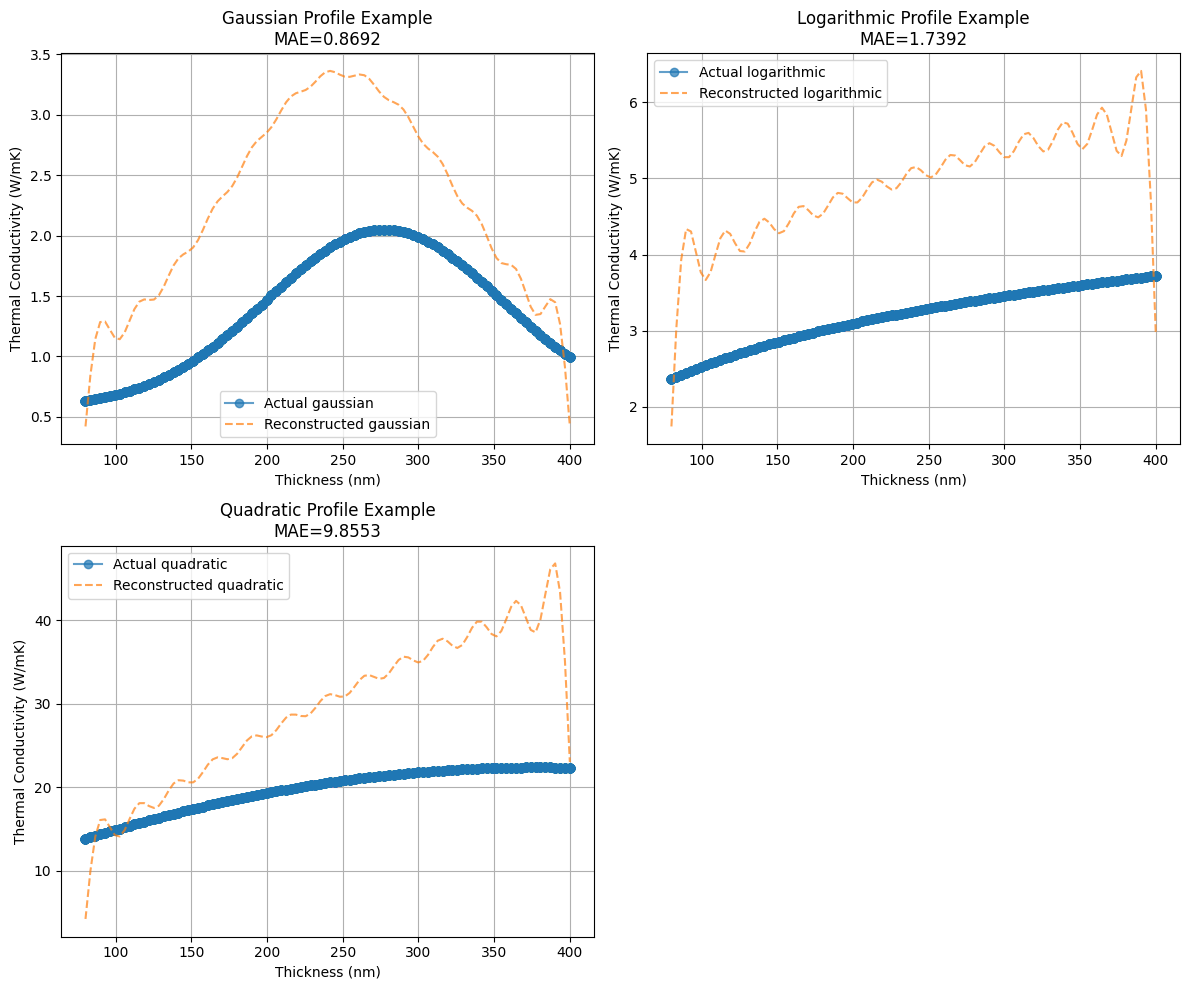

In [1]:
#main code #DO NOT delete


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=25):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=25):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=52):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=25):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        # 'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10  # Increased patience
    counter = 0
    epochs = 50
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation (using test set as proxy)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model_GLQ.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model_GLQ.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample a few examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue

        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile Example\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('thermal_conductivity_profiles_N25.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'thermal_conductivity_profiles_N25.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on gaussian distribution...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Processed 590000 data points for gaussian distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 472000 samples
Test set: 118000 samples
Starting model training...
Epoch 1/50: Train Loss = 0.642461, Val Loss = 0.611197
Epoch 2/50: Train Loss = 0.616130, Val Loss = 0.596652
Epoch 3/50: Train Loss = 0.606946, Val Loss = 0.589218
Epoch 4/50: Train Loss = 0.600661, Val Loss = 0.589264
Epoch 5/50: Train Loss = 0.596844, Val Loss = 0.576738
Epoch 6/50: Train Loss = 0.592717, Val Loss = 0.573674
Epoch 7/50: Train Loss = 0.589863, Val Loss = 0.570116
Epoch 8/50: Train Loss = 0.586818, Val Loss = 0.566782
Epoch 9/50: Train Loss = 0.584893, Val Loss = 0.565663
Epoch 10/50: Train Loss = 0.582693, Val Loss = 0.560578
Epoch 11/50: Train Loss = 0.580939, Val Loss = 0.

<ipython-input-6-dd4e78fe3bb3>:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 901.61 seconds
Visualizations saved to 'gaussian_profiles.png' and 'loss_curve.png'


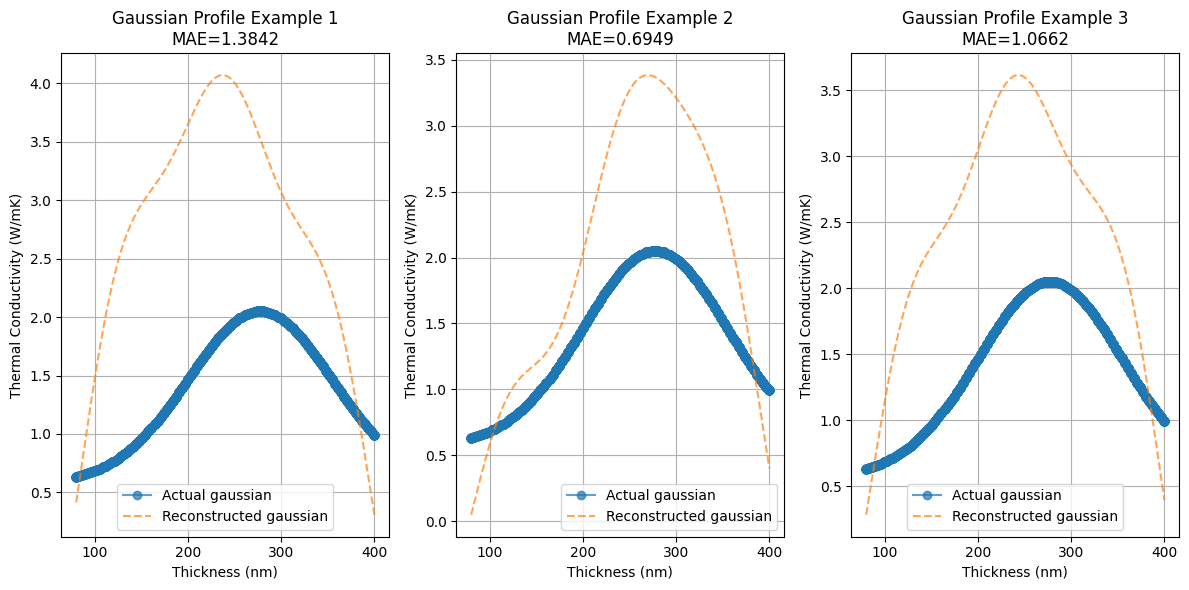

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=5):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=5)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=5, target_distribution='gaussian'):
    """Process data focusing only on the target distribution (gaussian)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=12):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=5):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on gaussian
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=5,  # Reduced Fourier terms
        target_distribution='gaussian'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for gaussian distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['gaussian'].keys())[0]
        x_values = reference_profiles['gaussian'][eq_id]['x']
        y_actual = reference_profiles['gaussian'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=5)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual gaussian', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed gaussian', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'Gaussian Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('gaussian_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'gaussian_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on logarithmic distribution...
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Processed 590000 data points for logarithmic distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 472000 samples
Test set: 118000 samples
Starting model training...
Epoch 1/50: Train Loss = 0.286822, Val Loss = 0.261684
Epoch 2/50: Train Loss = 0.261119, Val Loss = 0.248171
Epoch 3/50: Train Loss = 0.251084, Val Loss = 0.241656
Epoch 4/50: Train Loss = 0.243357, Val Loss = 0.238706
Epoch 5/50: Train Loss = 0.238600, Val Loss = 0.235254
Epoch 6/50: Train Loss = 0.236272, Val Loss = 0.236131
Epoch 7/50: Train Loss = 0.234592, Val Loss = 0.234607
Epoch 8/50: Train Loss = 0.232981, Val Loss = 0.237335
Epoch 9/50: Train Loss = 0.231750, Val Loss = 0.232557
Epoch 10/50: Train Loss = 0.230565, Val Loss = 0.230158
Epoch 11/50: Train Loss = 0.229835, V

<ipython-input-12-9ab0e7954f5a>:254: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 1054.66 seconds
Visualizations saved to 'logarithmic_profiles.png' and 'loss_curve.png'


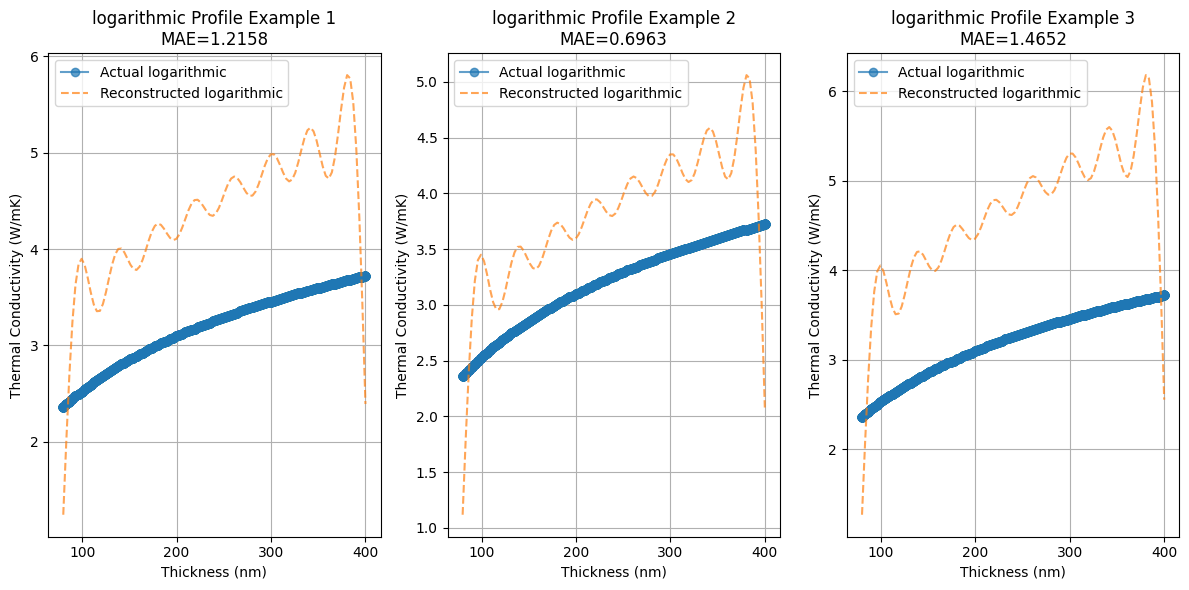

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

# def fourier_series_coefficients(y_values, x_values, N=5):
#     """Convert a distribution into Fourier series coefficients with reduced terms (N=5)."""
def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=15)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15, target_distribution='logarithmic'):
    """Process data focusing only on the target distribution (logarithmic)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=12):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on logarithmic
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=15,  # Reduced Fourier terms
        target_distribution='logarithmic'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for logarithmic distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['logarithmic'].keys())[0]
        x_values = reference_profiles['logarithmic'][eq_id]['x']
        y_actual = reference_profiles['logarithmic'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual logarithmic', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed logarithmic', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'logarithmic Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('logarithmic_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'logarithmic_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on quadratic distribution...
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 560500 data points for quadratic distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 448400 samples
Test set: 112100 samples
Starting model training...
Epoch 1/50: Train Loss = 0.149962, Val Loss = 0.126148
Epoch 2/50: Train Loss = 0.129943, Val Loss = 0.130622
Epoch 3/50: Train Loss = 0.127116, Val Loss = 0.127364
Epoch 4/50: Train Loss = 0.124628, Val Loss = 0.130729
Epoch 5/50: Train Loss = 0.123543, Val Loss = 0.126317
Epoch 6/50: Train Loss = 0.122890, Val Loss = 0.127932
Epoch 7/50: Train Loss = 0.122432, Val Loss = 0.128869
Epoch 8/50: Train Loss = 0.122073, Val Loss = 0.125105
Epoch 9/50: Train Loss = 0.121637, Val Loss = 0.128237
Epoch 10/50: Train Loss = 0.121248, Val Loss = 0.127871
Epoch 11/50: Train Loss = 0.120964, Val Loss 

<ipython-input-9-f7c2b648ea6c>:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 482.81 seconds
Visualizations saved to 'quadratic_profiles.png' and 'loss_curve.png'


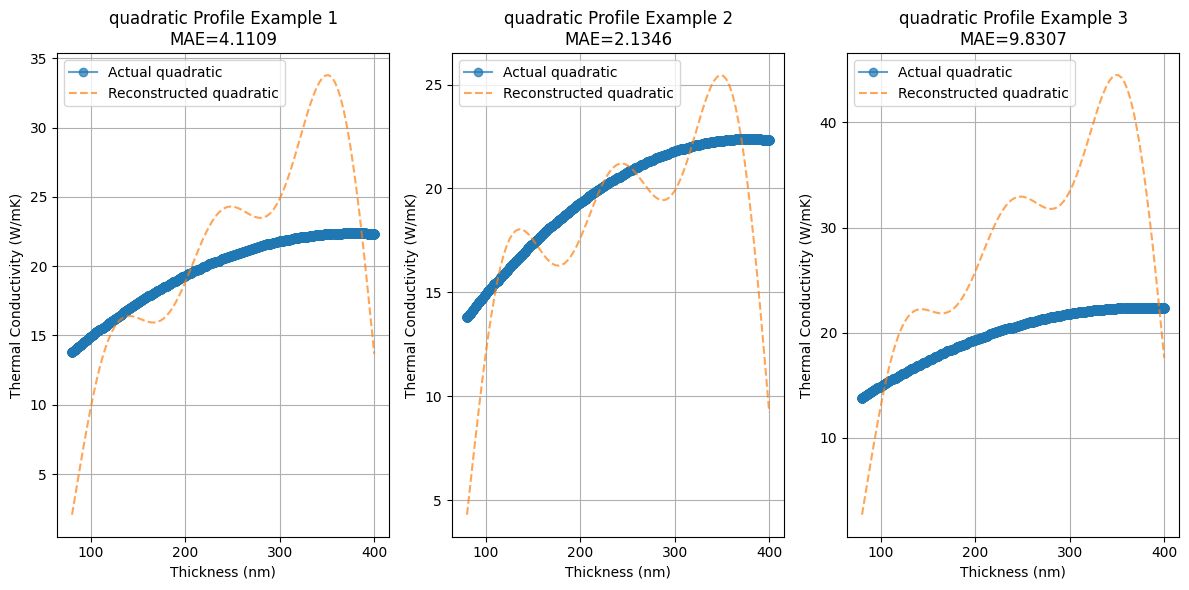

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=5):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=5)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=5, target_distribution='quadratic'):
    """Process data focusing only on the target distribution (quadratic)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=12):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=5):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on quadratic
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=5,  # Reduced Fourier terms
        target_distribution='quadratic'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for quadratic distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['quadratic'].keys())[0]
        x_values = reference_profiles['quadratic'][eq_id]['x']
        y_actual = reference_profiles['quadratic'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=5)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual quadratic', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed quadratic', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'quadratic Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('quadratic_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'quadratic_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on quadratic distribution...
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 560500 data points for quadratic distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 448400 samples
Test set: 112100 samples
Starting model training...
Epoch 1/50: Train Loss = 0.114593, Val Loss = 0.112689
Epoch 2/50: Train Loss = 0.095585, Val Loss = 0.125782
Epoch 3/50: Train Loss = 0.091241, Val Loss = 0.133656
Epoch 4/50: Train Loss = 0.088282, Val Loss = 0.135277
Epoch 5/50: Train Loss = 0.085971, Val Loss = 0.147804
Epoch 6/50: Train Loss = 0.083958, Val Loss = 0.149215
Epoch 7/50: Train Loss = 0.082332, Val Loss = 0.155355
Epoch 8/50: Train Loss = 0.080899, Val Loss = 0.166634
Epoch 9/50: Train Loss = 0.079176, Val Loss = 0.157254
Epoch 10/50: Train Loss = 0.077995, Val Loss = 0.156934
Epoch 11/50: Train Loss = 0.076771, Val Loss 

<ipython-input-14-92322df258cb>:259: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 421.97 seconds
Visualizations saved to 'quadratic_profiles.png' and 'loss_curve.png'


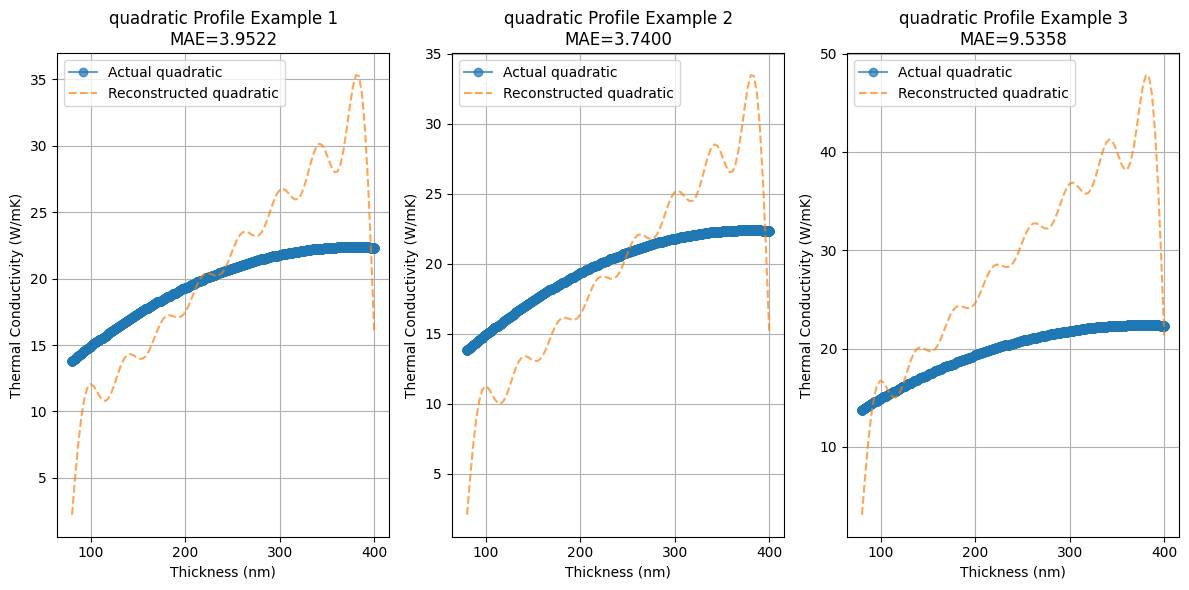

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=15)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15, target_distribution='quadratic'):
    """Process data focusing only on the target distribution (quadratic)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=32):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on quadratic
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=15,  # Reduced Fourier terms
        target_distribution='quadratic'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for quadratic distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['quadratic'].keys())[0]
        x_values = reference_profiles['quadratic'][eq_id]['x']
        y_actual = reference_profiles['quadratic'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual quadratic', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed quadratic', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'quadratic Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('quadratic_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'quadratic_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with reduced complexity...
Processing data, focusing on polynomial distribution...
Loading polynomial data from thermal_conductivity_polynomial_20250207_155543.csv
Processed 253700 data points for polynomial distribution
Normalizing data...
Splitting data into train/test sets...
Training set: 202960 samples
Test set: 50740 samples
Starting model training...
Epoch 1/50: Train Loss = 0.894360, Val Loss = 0.871295
Epoch 2/50: Train Loss = 0.876182, Val Loss = 0.865035
Epoch 3/50: Train Loss = 0.872565, Val Loss = 0.864963
Epoch 4/50: Train Loss = 0.871043, Val Loss = 0.863475
Epoch 5/50: Train Loss = 0.870413, Val Loss = 0.863525
Epoch 6/50: Train Loss = 0.870074, Val Loss = 0.863407
Epoch 7/50: Train Loss = 0.869851, Val Loss = 0.863483
Epoch 8/50: Train Loss = 0.869443, Val Loss = 0.865010
Epoch 9/50: Train Loss = 0.869225, Val Loss = 0.864492
Epoch 10/50: Train Loss = 0.869752, Val Loss = 0.863333
Epoch 11/50: Train Loss = 0.869405, Val Lo

<ipython-input-10-f655c09600a1>:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Analysis completed in 225.54 seconds
Visualizations saved to 'polynomial_profiles.png' and 'loss_curve.png'


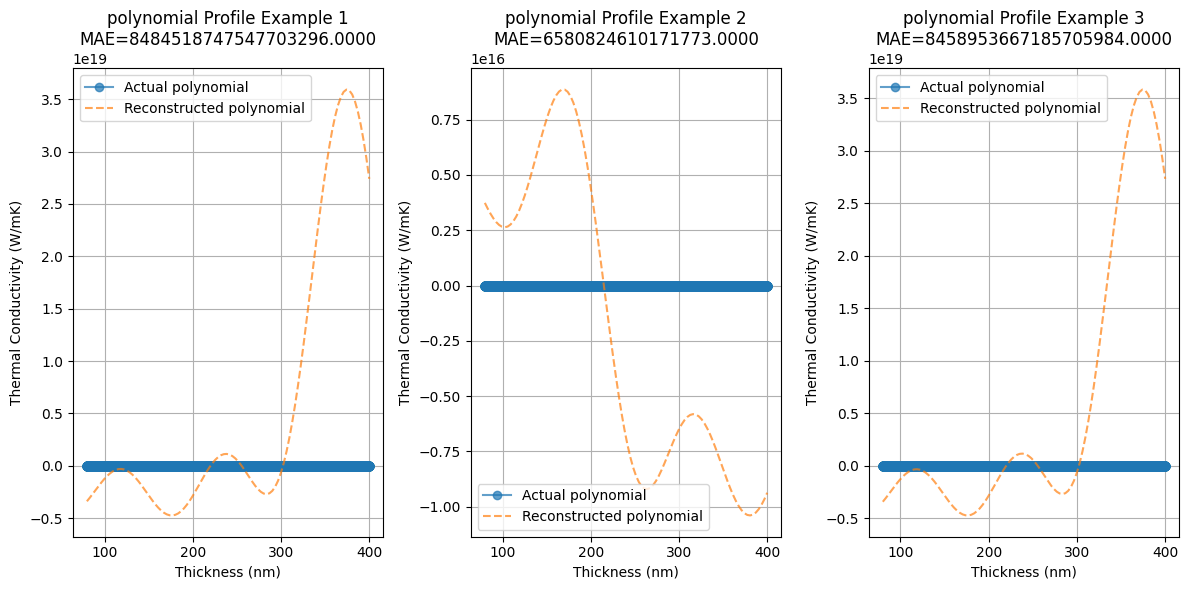

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=5):
    """Convert a distribution into Fourier series coefficients with reduced terms (N=5)."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=5, target_distribution='polynomial'):
    """Process data focusing only on the target distribution (polynomial)."""
    features_list, targets_list = [], []
    reference_profiles = {}

    print(f"Processing data, focusing on {target_distribution} distribution...")

    # Keep all files in the dictionary but only process the target one
    for eq_type, file_path in data_files.items():
        if eq_type == target_distribution:
            print(f"Loading {eq_type} data from {file_path}")
            df = pd.read_csv(file_path)
            reference_profiles[eq_type] = {}

            for eq_id in df['Equation_ID'].unique():
                eq_data = df[df['Equation_ID'] == eq_id]

                # Sort by thickness for consistency
                sort_idx = np.argsort(eq_data['x (Thickness)'].values)
                x_values = eq_data['x (Thickness)'].values[sort_idx]
                y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

                # Store reference profile for later visualization
                if eq_id not in reference_profiles[eq_type]:
                    reference_profiles[eq_type][eq_id] = {
                        'x': x_values,
                        'y': y_values
                    }

                # Calculate Fourier coefficients once per equation
                coeffs = fourier_series_coefficients(y_values, x_values, N=N)

                # Create a row for each x value
                for i in range(len(x_values)):
                    features_list.append([
                        x_values[i],
                        eq_data['ModelRatio'].values[sort_idx][i],
                        eq_data['Tdelay'].values[sort_idx][i]
                    ])
                    targets_list.append(coeffs + [y_values[i]])

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points for {target_distribution} distribution")
    return features_df, targets_df, reference_profiles

# =============================
# 3. Model Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=12):  # 11 Fourier coefficients + 1 thermal conductivity
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 4. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=5):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 5. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis with reduced complexity...")

    # Load Data - keep all files in the list
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'polynomial': 'thermal_conductivity_polynomial_20250207_155543.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data - focus only on polynomial
    features_df, targets_df, reference_profiles = process_data(
        data_files,
        N=5,  # Reduced Fourier terms
        target_distribution='polynomial'
    )

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test = train_test_split(
        features_normalized, targets_normalized,
        test_size=0.2, random_state=42
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curve.png', dpi=300)
    plt.close()

    # Visualize results for polynomial distribution
    plt.figure(figsize=(12, 6))

    # Get a few samples from test set
    num_samples = min(3, len(X_test))

    for i in range(num_samples):
        # Get sample features
        sample_features = X_test[i]

        # Get reference profile
        eq_id = list(reference_profiles['polynomial'].keys())[0]
        x_values = reference_profiles['polynomial'][eq_id]['x']
        y_actual = reference_profiles['polynomial'][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=5)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(1, num_samples, i+1)
        plt.plot(x_values, y_actual, 'o-', label='Actual polynomial', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label='Reconstructed polynomial', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'polynomial Profile Example {i+1}\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('polynomial_profiles.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'polynomial_profiles.png' and 'loss_curve.png'")

if __name__ == "__main__":
    main()


In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions (5 different architectures)
# =============================

class FourierNN_Model1(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        self.name = "ReLU_Dropout"

    def forward(self, x):
        return self.network(x)

class FourierNN_Model2(nn.Module):
    """GELU activation with batch normalization"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Linear(64, output_dim)
        )
        self.name = "GELU_BatchNorm"

    def forward(self, x):
        return self.network(x)

class FourierNN_Model3(nn.Module):
    """Tanh activation with L2 regularization"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, output_dim)
        )
        self.name = "Tanh_L2Reg"
        # L2 regularization will be applied via weight_decay in optimizer

    def forward(self, x):
        return self.network(x)

class FourierNN_Model4(nn.Module):
    """Leaky ReLU with residual connections"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, 128)
        self.hidden1 = nn.Linear(128, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.hidden3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, output_dim)
        self.activation = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.2)
        self.name = "LeakyReLU_Residual"

    def forward(self, x):
        x1 = self.activation(self.input_layer(x))
        x1 = self.dropout(x1)
        
        x2 = self.activation(self.hidden1(x1))
        x2 = self.dropout(x2)
        x2 = x2 + x1  # Residual connection
        
        x3 = self.activation(self.hidden2(x2))
        x3 = self.dropout(x3)
        x3 = x3 + x2  # Residual connection
        
        x4 = self.activation(self.hidden3(x3))
        output = self.output_layer(x4)
        return output

class FourierNN_Model5(nn.Module):
    """Deeper SiLU (Swish) activation model"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, output_dim)
        )
        self.name = "SiLU_Deeper"

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Training Function
# =============================

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, N, epochs=50):
    """Train model with early stopping and return metrics"""
    print(f"Training {model.name} model...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    train_losses = []
    val_losses = []
    
    # Create directory for model saving if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
        
        # Learning rate scheduler step
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            model_path = f'models/model_N{N}_{model.name}.pth'
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model to {model_path}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load(f'models/model_N{N}_{model.name}.pth'))
    
    return model, train_losses, val_losses, best_loss

# =============================
# 7. Evaluation Function
# =============================

def evaluate_model(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, N):
    """Evaluate model on test set and visualize results"""
    model.eval()
    
    # Create directory for visualizations if it doesn't exist
    os.makedirs('visualizations', exist_ok=True)
    
    # Sample examples from each distribution type for visualization
    eq_types = list(reference_profiles.keys())
    plt.figure(figsize=(12, 10))
    
    mae_values = {}
    
    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]
        
        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']
        
        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
        
        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
        
        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
        
        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)
        mae_values[eq_type] = mae
        
        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/profiles_N{N}_{model.name}.png', dpi=300)
    plt.close()
    
    return mae_values



def create_model(input_dim, output_dim, config):
    """Create a model with the specified configuration"""
    layers = []
    prev_dim = input_dim
    
    # Add input features for polynomial terms
    input_dim += 4  # For x², x³, sin(x), cos(x)
    
    # Build layers according to configuration
    for dim in config["layers"]:
        layers.append(nn.Linear(prev_dim, dim))
        layers.append(config["activation"])
        layers.append(nn.Dropout(config["dropout"]))
        prev_dim = dim
    
    # Output layer
    layers.append(nn.Linear(prev_dim, output_dim))
    
    model = nn.Sequential(*layers)
    return model

def visualize_model_results(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, model_name):
    """Visualize results for a single model and return MAE values"""
    model.eval()
    eq_types = list(reference_profiles.keys())
    plt.figure(figsize=(12, 10))
    
    mae_values = {}
    
    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]
        
        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']
        
        # Add engineered features
        sample_features_enhanced = np.concatenate([
            sample_features,
            np.array([sample_features[0]**2, sample_features[0]**3, 
                     np.sin(sample_features[0]*0.01), np.cos(sample_features[0]*0.01)])
        ])
        
        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features_enhanced.reshape(1, -1))).numpy()[0]
        
        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
        
        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values)
        
        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)
        mae_values[eq_type] = mae
        
        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/{model_name}_profiles.png', dpi=300)
    plt.close()
    
    return mae_values
  
if __name__ == "__main__":
    main()


Starting thermal conductivity profile analysis with multiple models...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...

Training model: ReLU_Standard


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.061277, Val Loss = 0.042172
Epoch 2/50: Train Loss = 0.054003, Val Loss = 0.040210
Epoch 3/50: Train Loss = 0.053228, Val Loss = 0.039449
Epoch 4/50: Train Loss = 0.052806, Val Loss = 0.039728
Epoch 5/50: Train Loss = 0.052571, Val Loss = 0.040754
Epoch 6/50: Train Loss = 0.052463, Val Loss = 0.038823
Epoch 7/50: Train Loss = 0.052329, Val Loss = 0.040640
Epoch 8/50: Train Loss = 0.052197, Val Loss = 0.039288
Epoch 9/50: Train Loss = 0.052115, Val Loss = 0.039103
Epoch 10/50: Train Loss = 0.051807, Val Loss = 0.039019
Epoch 11/50: Train Loss = 0.051982, Val Loss = 0.039882
Epoch 12/50: Train Loss = 0.051787, Val Loss = 0.039356
Epoch 13/50: Train Loss = 0.050477, Val Loss = 0.038343
Epoch 14/50: Train Loss = 0.050358, Val Loss = 0.037592
Epoch 15/50: Train Loss = 0.050149, Val Loss = 0.037533
Epoch 16/50: Train Loss = 0.050144, Val Loss = 0.037306
Epoch 17/50: Train Loss = 0.050032, Val Loss = 0.037410
Epoch 18/50: Train Loss = 0.050057, Val Loss = 0.037349
E

/tmp/ipykernel_519930/468736156.py:490: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{config["name"]}_best.pth'))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x7 and 3x256)

<Figure size 1200x1000 with 0 Axes>

In [ ]:
# def main():
#     start_time = time.time()
#     print("Starting thermal conductivity profile analysis with multiple models...")
    
#     # Create directories for storing results
#     os.makedirs('models', exist_ok=True)
#     os.makedirs('visualizations', exist_ok=True)
    
#     # Load Data
#     data_files = {
#         'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
#         'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
#         'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
#     }
    
#     # Process data
#     features_df, targets_df, eq_ids, reference_profiles = process_data(data_files)
    
#     # Data Normalization
#     print("Normalizing data...")
#     feature_scaler = StandardScaler()
#     features_normalized = feature_scaler.fit_transform(features_df.values)

#     target_scaler = StandardScaler()
#     targets_normalized = target_scaler.fit_transform(targets_df.values)

#     # Split into training and testing sets
#     X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
#         features_normalized, targets_normalized, eq_ids,
#         test_size=0.2, random_state=42, stratify=eq_ids
#     )
    
#     # Create datasets and dataloaders
#     train_dataset = ThermalConductivityDataset(X_train, y_train)
#     test_dataset = ThermalConductivityDataset(X_test, y_test)
#     train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=64)
    
#     # Define different model configurations
#     model_configs = [
#         {"name": "ReLU_Standard", "activation": nn.ReLU(), "dropout": 0.2, "layers": [256, 128, 64]},
#         {"name": "Tanh_Deep", "activation": nn.Tanh(), "dropout": 0.3, "layers": [256, 256, 128, 64]},
#         {"name": "GELU_Wide", "activation": nn.GELU(), "dropout": 0.2, "layers": [512, 256, 128]},
#         {"name": "LeakyReLU_Medium", "activation": nn.LeakyReLU(0.1), "dropout": 0.25, "layers": [256, 192, 128, 64]},
#         {"name": "SiLU_Standard", "activation": nn.SiLU(), "dropout": 0.2, "layers": [256, 128, 64]}
#     ]
    
#     # Store results for all models
#     all_results = {}
    
#     # Train and evaluate each model configuration
#     for config in model_configs:
#         print(f"\n{'='*50}")
#         print(f"Training model: {config['name']}")
#         print(f"{'='*50}")
        
#         # Create model with this configuration
#         model = create_model(X_train.shape[1], y_train.shape[1], config)
        
#         # Train model
#         criterion = nn.MSELoss()
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#         scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        
#         # Training loop
#         best_loss = float('inf')
#         patience = 10
#         counter = 0
#         train_losses = []
#         val_losses = []
        
#         for epoch in range(50):  # 50 epochs max
#             # Training phase
#             model.train()
#             train_loss = 0
#             for features_batch, targets_batch in train_loader:
#                 optimizer.zero_grad()
#                 outputs = model(features_batch)
#                 loss = criterion(outputs, targets_batch)
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()
#                 train_loss += loss.item()
            
#             avg_train_loss = train_loss / len(train_loader)
#             train_losses.append(avg_train_loss)
            
#             # Validation phase
#             model.eval()
#             val_loss = 0
#             with torch.no_grad():
#                 for features_batch, targets_batch in test_loader:
#                     outputs = model(features_batch)
#                     loss = criterion(outputs, targets_batch)
#                     val_loss += loss.item()
            
#             avg_val_loss = val_loss / len(test_loader)
#             val_losses.append(avg_val_loss)
#             scheduler.step(avg_val_loss)
            
#             print(f"Epoch {epoch+1}/50: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
            
#             # Early stopping
#             if avg_val_loss < best_loss:
#                 best_loss = avg_val_loss
#                 counter = 0
#                 torch.save(model.state_dict(), f'models/{config["name"]}_best.pth')
#             else:
#                 counter += 1
#                 if counter >= patience:
#                     print(f"Early stopping triggered at epoch {epoch+1}")
#                     break
        
#         # Load best model
#         model.load_state_dict(torch.load(f'models/{config["name"]}_best.pth'))
        
#         # Immediately visualize results for this model
#         print(f"Generating visualizations for {config['name']}...")
#         mae_values = visualize_model_results(model, test_loader, target_scaler, reference_profiles, 
#                                             eq_test, X_test, config["name"])
        
#         # Store results
#         all_results[config["name"]] = {
#             "train_losses": train_losses,
#             "val_losses": val_losses,
#             "best_val_loss": best_loss,
#             "mae_values": mae_values
#         }
        
#         # Plot training curves for this model
#         plt.figure(figsize=(10, 6))
#         plt.plot(train_losses, label='Training Loss')
#         plt.plot(val_losses, label='Validation Loss')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.title(f'Training and Validation Loss - {config["name"]}')
#         plt.legend()
#         plt.grid(True)
#         plt.savefig(f'visualizations/{config["name"]}_loss_curve.png', dpi=300)
#         plt.close()
        
#         print(f"Results for {config['name']} saved.")
    
#     # After all models are trained, print comparison
#     print("\n" + "="*50)
#     print("Model Comparison Summary")
#     print("="*50)
    
#     for model_name, results in all_results.items():
#         print(f"\nModel: {model_name}")
#         print(f"Best Validation Loss: {results['best_val_loss']:.6f}")
#         print("MAE Values by Distribution Type:")
#         for eq_type, mae in results['mae_values'].items():
#             print(f"  - {eq_type}: {mae:.4f}")
    
#     end_time = time.time()
#     print(f"\nComplete analysis finished in {end_time - start_time:.2f} seconds")

Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples
Starting model training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.072775, Val Loss = 0.054793
Saved best model (Val Loss: 0.054793)
Epoch 2/50: Train Loss = 0.064100, Val Loss = 0.059497
Epoch 3/50: Train Loss = 0.062493, Val Loss = 0.047907
Saved best model (Val Loss: 0.047907)
Epoch 4/50: Train Loss = 0.062268, Val Loss = 0.041412
Saved best model (Val Loss: 0.041412)
Epoch 5/50: Train Loss = 0.061576, Val Loss = 0.047544
Epoch 6/50: Train Loss = 0.060910, Val Loss = 0.046157
Epoch 7/50: Train Loss = 0.061162, Val Loss = 0.040121
Saved best model (Val Loss: 0.040121)
Epoch 8/50: Train Loss = 0.060583, Val Loss = 0.046742
Epoch 9/50: Train Loss = 0.060343, Val Loss = 0.040751
Epoch 10/50: Train Loss = 0.059950, Val Loss = 0.049221
Epoch 11/50: Train Loss = 0.060224, Val Loss = 0.043104
Epoch 12/50: Train Loss = 0.059994, Val Loss = 0.044540
Epoch 13/50: Train Loss = 0.060013, Val Loss = 0.047027
Epoch 14/50: Train Loss = 0.059049, Val Loss = 0.044358
Epoch 15/50: Train Loss = 0.058873, Val Loss = 0.044797
Epoch 16/50: Trai

/tmp/ipykernel_38956/1004139506.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model.pth'))


Evaluating model and generating visualizations...
Analysis completed in 1028.59 seconds
Visualizations saved to 'visualizations/thermal_conductivity_profiles_N10.png'


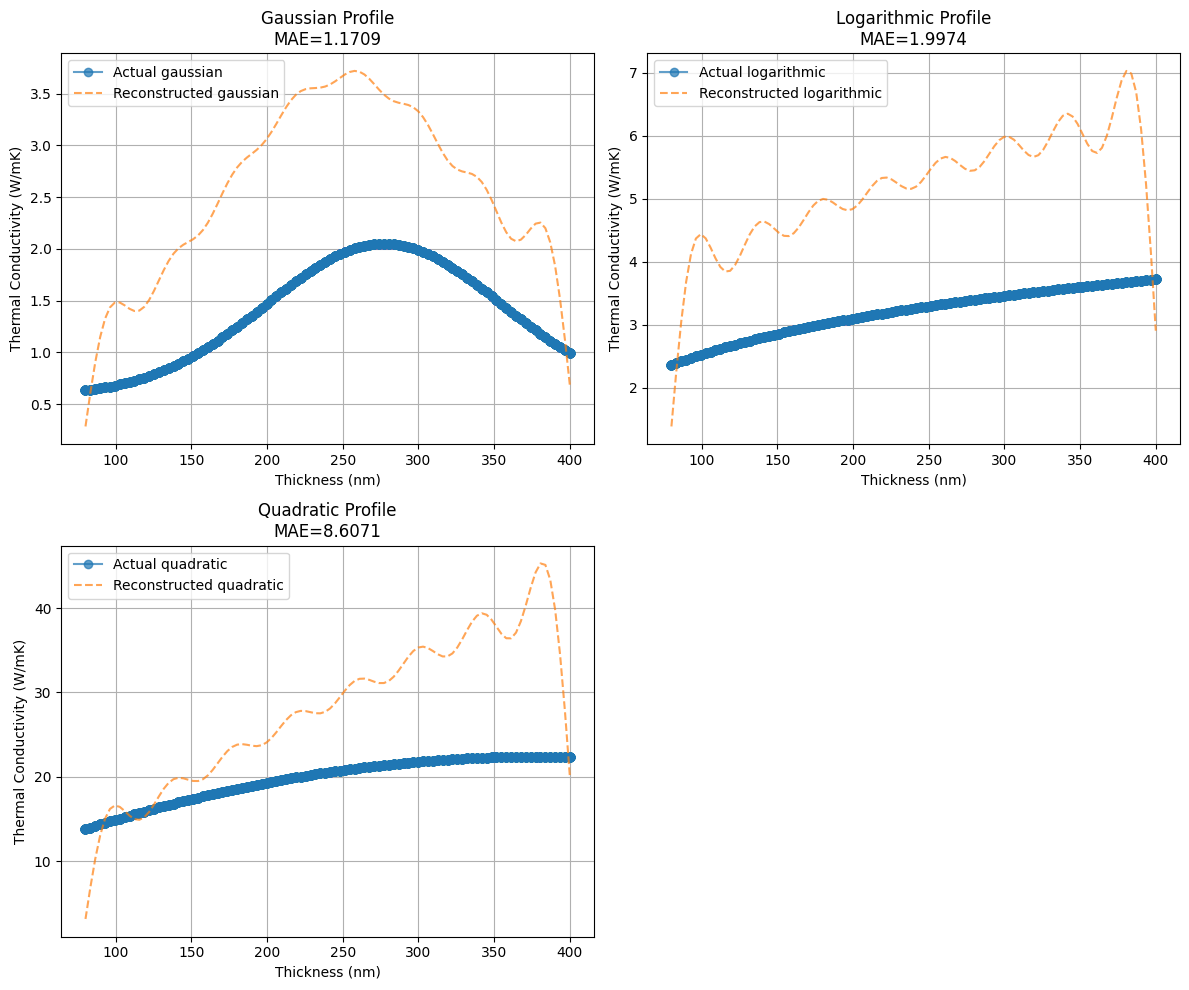

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions
# =============================

class FourierNN(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
        # Input layer
        nn.Linear(3, 32),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(32),
        
        # First hidden layer
        nn.Linear(32, 64),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(64),
        nn.Dropout(0.1),
        
        # Second hidden layer
        nn.Linear(64, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),
        nn.Dropout(0.15),
        
        # Third hidden layer
        nn.Linear(128, 64),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(64),
        nn.Dropout(0.1),
        
        # Output layer
        nn.Linear(64, 32)
    )
        self.name = "ReLU_Standard"

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Parameters
    N = 15  # Fourier series terms

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_model.pth')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_model.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve.png', dpi=300)
    plt.close()

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:models
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profileX_train.shape
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/thermal_conductivity_profiles_N10.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'visualizations/thermal_conductivity_profiles_N10.png'")

if __name__ == "__main__":
    main()


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/tmp/ipykernel_4080/1621758630.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from models/best_model.pth


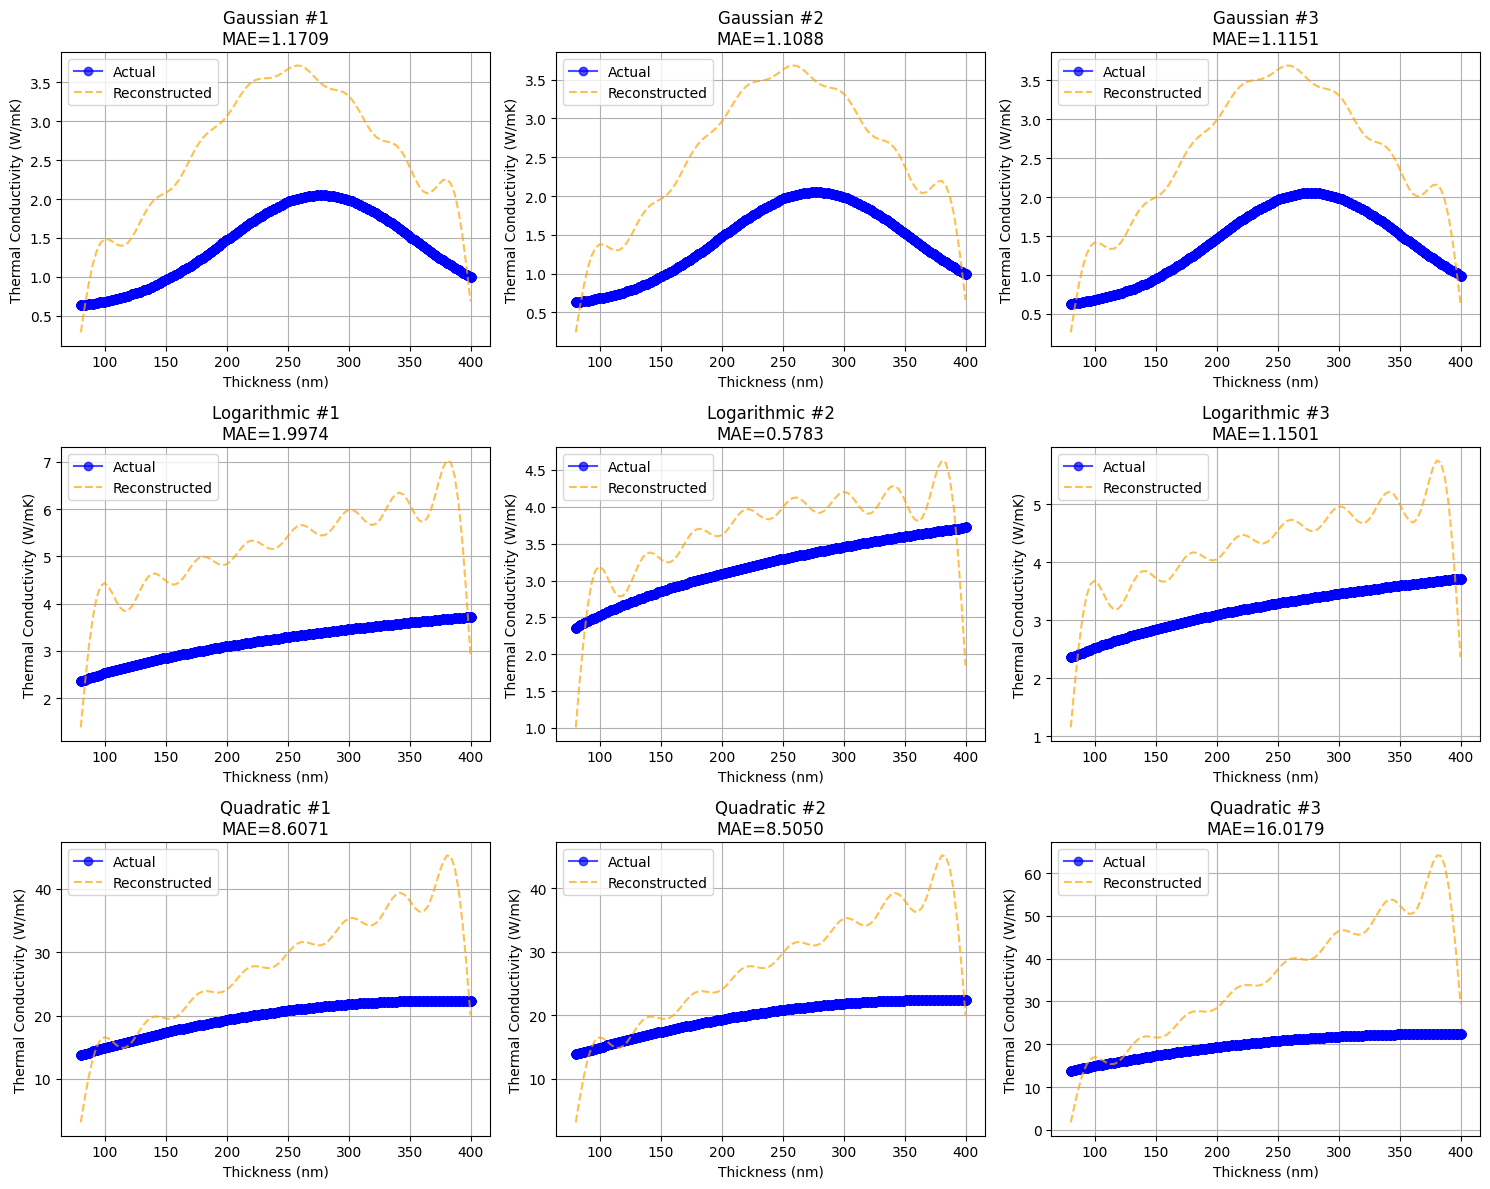


MAE Summary:
Gaussian: Mean MAE = 1.1316, Min = 1.1088, Max = 1.1709
Logarithmic: Mean MAE = 1.2419, Min = 0.5783, Max = 1.9974
Quadratic: Mean MAE = 11.0433, Min = 8.5050, Max = 16.0179


{'gaussian': [1.1708622063329959, 1.1088241090410837, 1.1151362185033178],
 'logarithmic': [1.997382918839494, 0.5782844998876564, 1.1501219512864496],
 'quadratic': [8.607126724749682, 8.504971128506003, 16.017938251754273]}

In [4]:
# Load the saved model and visualize multiple predictions
def visualize_saved_model(model_path='models/best_model.pth', samples_per_type=3):
    # Load data files
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=15)
    
    # Data Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Load model
    model = FourierNN(input_dim=3, output_dim=32)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
            
            # Calculate MAE
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N15.png', dpi=300)
    plt.show()
    
    # Print summary of MAE values
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    return mae_values

# Call the function to visualize multiple examples
visualize_saved_model(model_path='models/best_model.pth', samples_per_type=3)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions
# =============================

class FourierNN(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
        # Input layer
        nn.Linear(3, 64),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(64),
        
        # First hidden layer
        nn.Linear(64, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),
        nn.Dropout(0.1),
        
        # Second hidden layer
        nn.Linear(128, 256),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(256),
        nn.Dropout(0.15),
        
        # Third hidden layer
        nn.Linear(256, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),
        nn.Dropout(0.1),
        
        # Output layer
        nn.Linear(128, 32)
    )
        self.name = "ReLU_Standard"

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Parameters
    N = 15  # Fourier series terms

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_model_n15_Apr.pth')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_model_n15_Apr.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve.png', dpi=300)
    plt.close()

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:models
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profileX_train.shape
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/thermal_conductivity_profiles_N15_15Apr.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'visualizations/thermal_conductivity_profiles_N15_15Apr.png'")

if __name__ == "__main__":
    main()


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/tmp/ipykernel_8230/2996917146.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from models/best_model_n25.pth


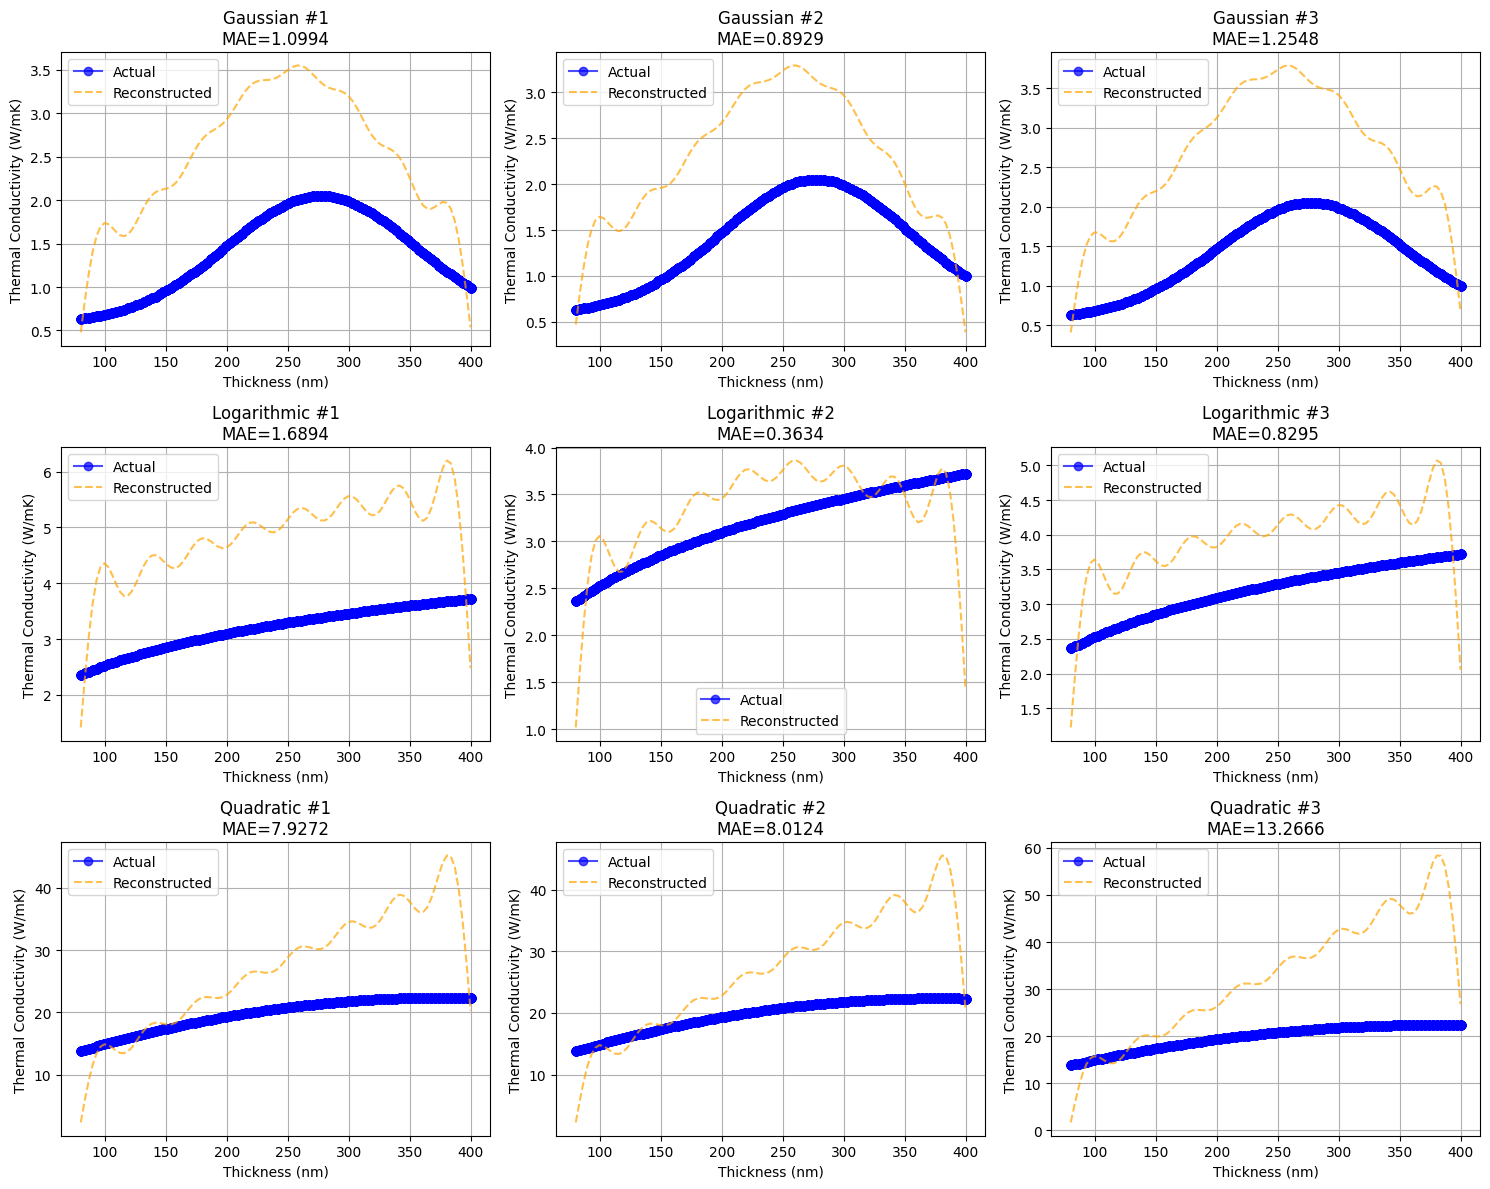


MAE Summary:
Gaussian: Mean MAE = 1.0824, Min = 0.8929, Max = 1.2548
Logarithmic: Mean MAE = 0.9607, Min = 0.3634, Max = 1.6894
Quadratic: Mean MAE = 9.7354, Min = 7.9272, Max = 13.2666


{'gaussian': [1.0993630502121432, 0.8928887280978802, 1.254808585966068],
 'logarithmic': [1.6893691772778956, 0.3633668154404159, 0.8295068808086349],
 'quadratic': [7.927220302572819, 8.012427081779967, 13.266550283977674]}

In [5]:
# Load the saved model and visualize multiple predictions
def visualize_saved_model(model_path='models/best_model.pth', samples_per_type=3):
    # Load data files
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=15)
    
    # Data Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Load model
    model = FourierNN(input_dim=3, output_dim=32)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
            
            # Calculate MAE
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N15_newPred.png', dpi=300)
    plt.show()
    
    # Print summary of MAE values
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    return mae_values

# Call the function to visualize multiple examples
visualize_saved_model(model_path='models/best_model_n25.pth', samples_per_type=3)


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/tmp/ipykernel_54483/702067865.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from models/best_model_n25.pth


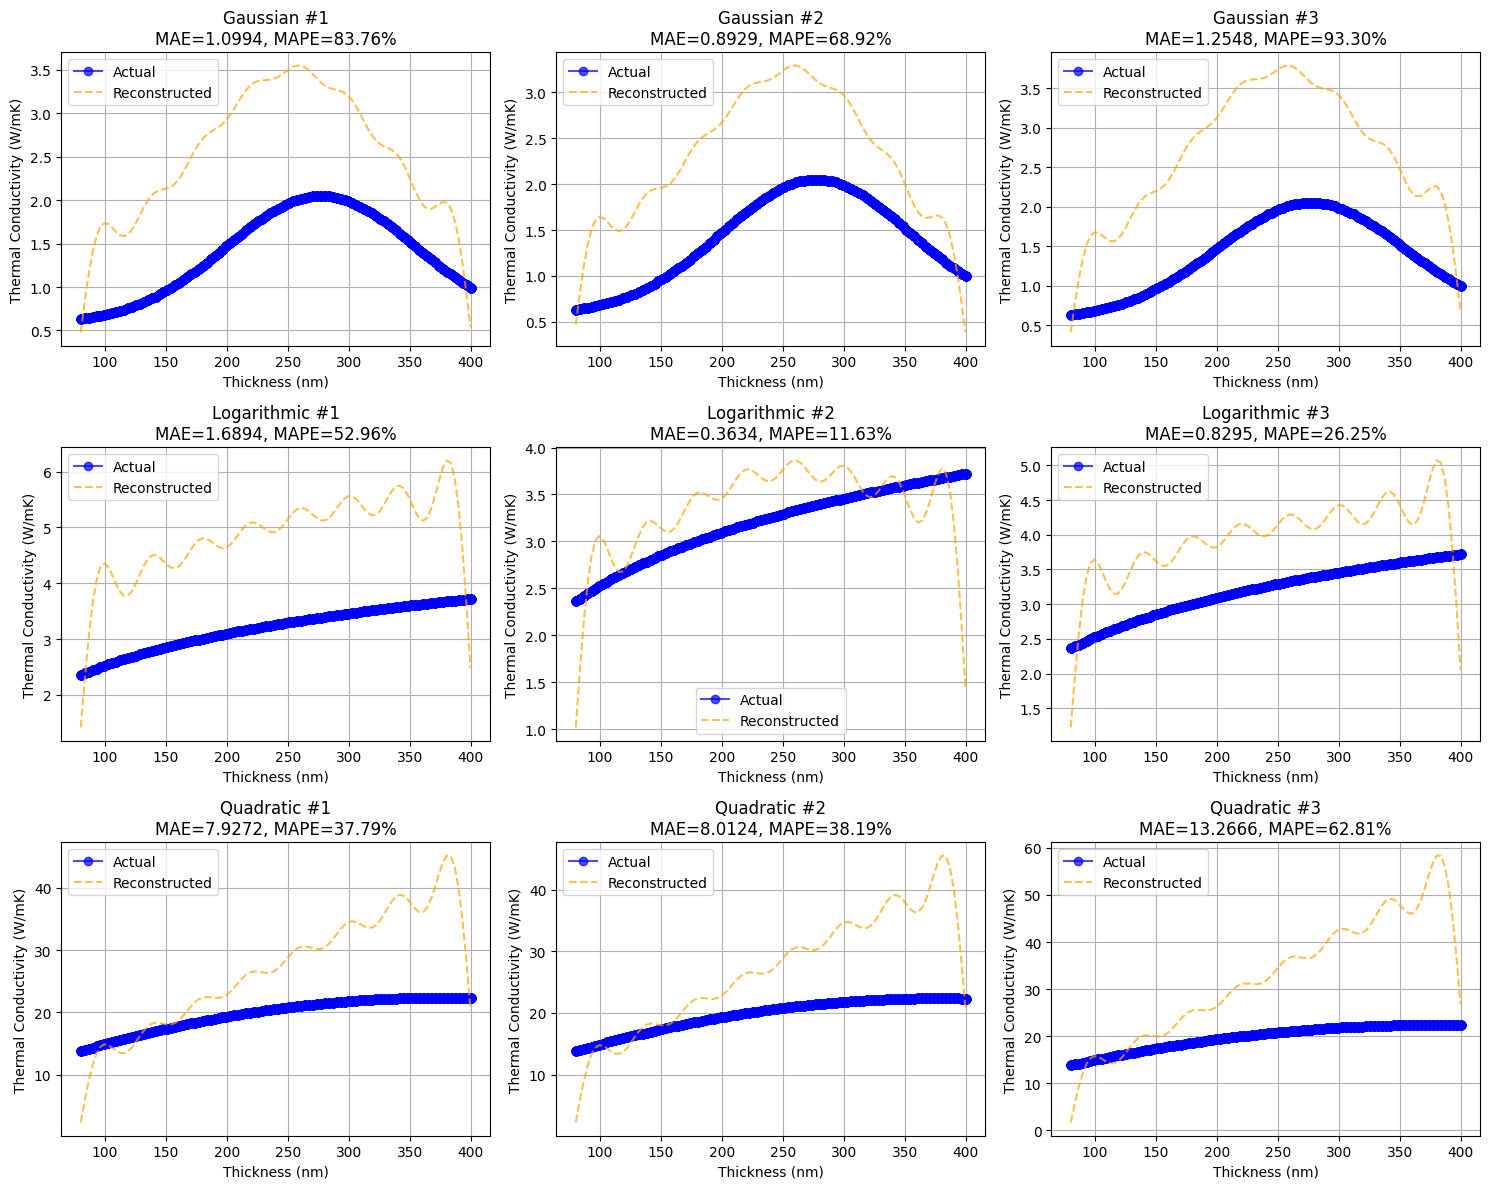


MAE Summary:
Gaussian: Mean MAE = 1.0824, Min = 0.8929, Max = 1.2548
Logarithmic: Mean MAE = 0.9607, Min = 0.3634, Max = 1.6894
Quadratic: Mean MAE = 9.7354, Min = 7.9272, Max = 13.2666

MAPE Summary (%):
Gaussian: Mean MAPE = 81.99%, Min = 68.92%, Max = 93.30%
Logarithmic: Mean MAPE = 30.28%, Min = 11.63%, Max = 52.96%
Quadratic: Mean MAPE = 46.26%, Min = 37.79%, Max = 62.81%


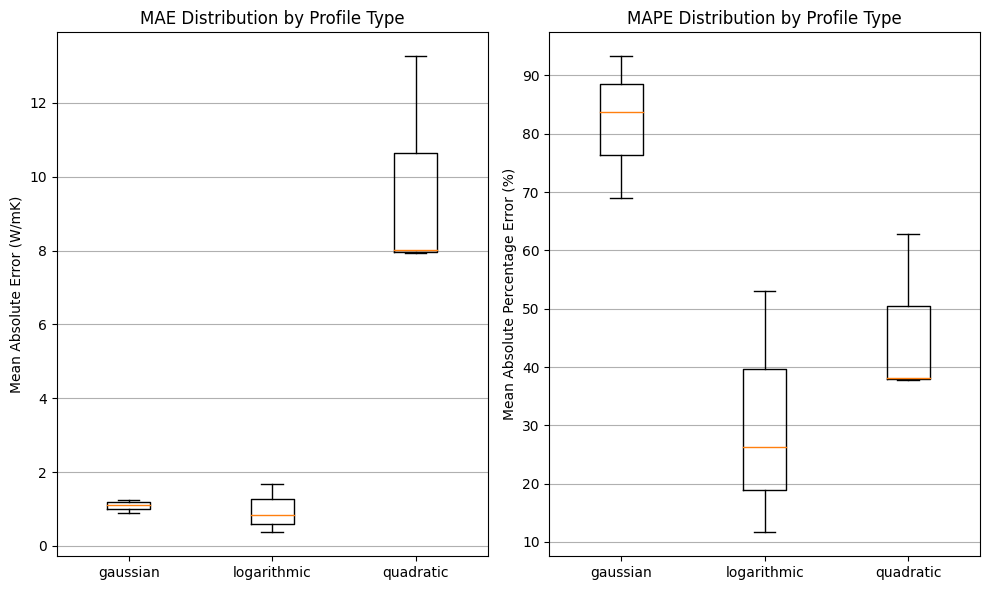

NameError: name 'eq_test' is not defined

In [8]:
data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
# Load the saved model and visualize multiple predictions with MAPE
def visualize_saved_model(model_path='models/best_model.pth', samples_per_type=5):
    # Load data files
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=15)
    
    # Data Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Load model
    model = FourierNN(input_dim=3, output_dim=32)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store error metrics for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    mape_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
            
            # Calculate MAE
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Calculate MAPE (Mean Absolute Percentage Error)
            # Avoid division by zero by adding a small epsilon to actual values
            epsilon = 1e-10
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values[eq_type].append(mape)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N15_with_mape.png', dpi=300)
    plt.show()
    
    # Print summary of error metrics
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    print("\nMAPE Summary (%):")
    for eq_type, mapes in mape_values.items():
        print(f"{eq_type.capitalize()}: Mean MAPE = {np.mean(mapes):.2f}%, Min = {np.min(mapes):.2f}%, Max = {np.max(mapes):.2f}%")
    
    # Create additional visualization for error comparison
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    boxplot_data_mae = [mae_values[eq_type] for eq_type in eq_types]
    plt.boxplot(boxplot_data_mae, labels=eq_types)
    plt.title('MAE Distribution by Profile Type')
    plt.ylabel('Mean Absolute Error (W/mK)')
    plt.grid(True, axis='y')
    
    plt.subplot(1, 2, 2)
    boxplot_data_mape = [mape_values[eq_type] for eq_type in eq_types]
    plt.boxplot(boxplot_data_mape, labels=eq_types)
    plt.title('MAPE Distribution by Profile Type')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.grid(True, axis='y')
    
    plt.tight_layout()
    plt.savefig('visualizations/error_comparison.png', dpi=300)
    plt.show()
    
    return mae_values, mape_values

# Call the function to visualize multiple examples
mae_values, mape_values = visualize_saved_model(model_path='models/best_model_n25.pth', samples_per_type=3)

# Additional analysis: Calculate point-wise percentage errors 
def analyze_error_patterns(model_path='models/best_model_n25.pth'):
    """Analyze error patterns across different regions of the profiles"""
    # Load model and data (reusing code from above)
    # ...code to load model and data...
    
    # For each distribution type, select one example
    error_by_region = {}
    
    for eq_type in data_files.keys():
        # Get test sample
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        if not eq_indices:
            continue
            
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]
        
        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']
        
        # Predict and reconstruct
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
        
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
        
        # Calculate per-point percentage error
        point_errors = np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + 1e-10)) * 100
        
        # Divide profile into regions (beginning, middle, end)
        n_points = len(x_values)
        region_indices = [
            slice(0, n_points//3),                  # beginning
            slice(n_points//3, 2*n_points//3),      # middle
            slice(2*n_points//3, n_points)          # end
        ]
        
        error_by_region[eq_type] = {
            'beginning': np.mean(point_errors[region_indices[0]]),
            'middle': np.mean(point_errors[region_indices[1]]),
            'end': np.mean(point_errors[region_indices[2]])
        }
    
    # Visualize regional errors
    plt.figure(figsize=(10, 6))
    regions = ['beginning', 'middle', 'end']
    bar_width = 0.25
    r1 = np.arange(len(regions))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.bar(r1, [error_by_region['gaussian'][region] for region in regions], 
            width=bar_width, label='Gaussian', color='blue')
    plt.bar(r2, [error_by_region['logarithmic'][region] for region in regions], 
            width=bar_width, label='Logarithmic', color='green')
    plt.bar(r3, [error_by_region['quadratic'][region] for region in regions], 
            width=bar_width, label='Quadratic', color='red')
    
    plt.xlabel('Profile Region')
    plt.ylabel('Mean Percentage Error (%)')
    plt.title('Error Distribution Across Profile Regions')
    plt.xticks([r + bar_width for r in range(len(regions))], regions)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('visualizations/regional_error_analysis.png', dpi=300)
    plt.show()
    
    return error_by_region

# Call the function for deeper error analysis
error_patterns = analyze_error_patterns(model_path='models/best_model_n25.pth')


Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples
Starting model training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.064400, Val Loss = 0.048639
Saved best model (Val Loss: 0.048639)
Epoch 2/50: Train Loss = 0.056338, Val Loss = 0.050865
Epoch 3/50: Train Loss = 0.054600, Val Loss = 0.049306
Epoch 4/50: Train Loss = 0.054089, Val Loss = 0.043366
Saved best model (Val Loss: 0.043366)
Epoch 5/50: Train Loss = 0.053532, Val Loss = 0.042876
Saved best model (Val Loss: 0.042876)
Epoch 6/50: Train Loss = 0.053070, Val Loss = 0.042374
Saved best model (Val Loss: 0.042374)
Epoch 7/50: Train Loss = 0.052767, Val Loss = 0.040850
Saved best model (Val Loss: 0.040850)
Epoch 8/50: Train Loss = 0.052556, Val Loss = 0.040698
Saved best model (Val Loss: 0.040698)
Epoch 9/50: Train Loss = 0.052411, Val Loss = 0.041350
Epoch 10/50: Train Loss = 0.052222, Val Loss = 0.041748
Epoch 11/50: Train Loss = 0.051908, Val Loss = 0.037611
Saved best model (Val Loss: 0.037611)
Epoch 12/50: Train Loss = 0.052280, Val Loss = 0.041700
Epoch 13/50: Train Loss = 0.051662, Val Loss = 0.038960
Epoch 14/50: Tr

/tmp/ipykernel_54483/486334090.py:301: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_N20_Complex.pth'))


Evaluating model and generating visualizations...
Analysis completed in 4665.29 seconds
Visualizations saved to 'visualizations/thermal_conductivity_profiles_N20_Complex.png'


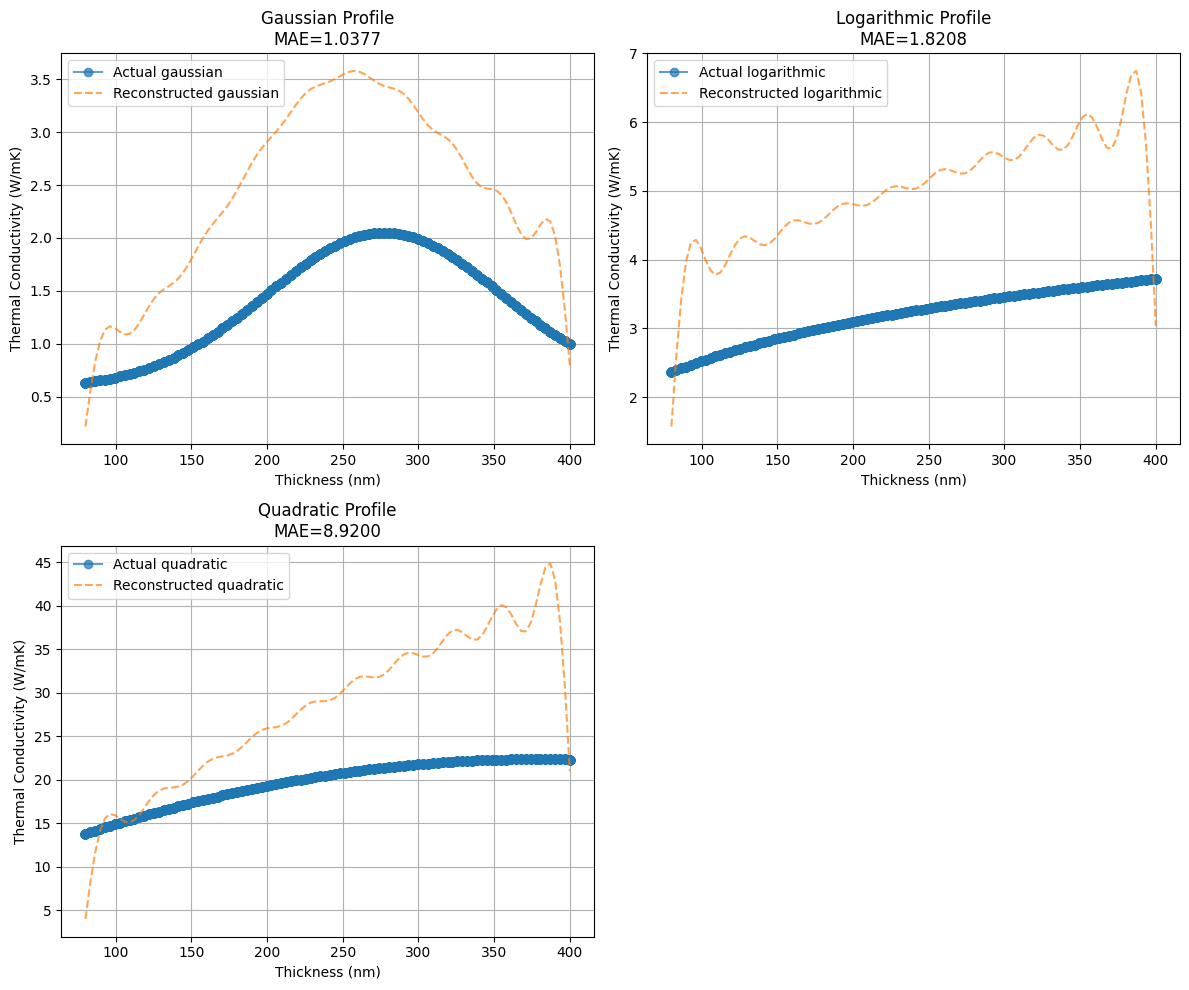

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=20):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=20):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions
# =============================

class FourierNN(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=42):
        super().__init__()
        self.network = nn.Sequential(
        # Input layer
        nn.Linear(3, 32),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(32),
        
        # First hidden layer
        nn.Linear(32, 64),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(64),
        nn.Dropout(0.1),
        
        # Second hidden layer
        nn.Linear(64, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),
        nn.Dropout(0.15),

        # Second hidden layer
        nn.Linear(128, 256),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(256),
        nn.Dropout(0.15),
        
        # Third hidden layer
        nn.Linear(256, 512),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(512),
        nn.Dropout(0.2),
        
        # Third hidden layer
        nn.Linear(512, 256),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(256),
        nn.Dropout(0.1),

        # Third hidden layer
        nn.Linear(256, 128),
        nn.LeakyReLU(0.1),
        nn.BatchNorm1d(128),

        # Output layer
        nn.Linear(128, 42)
    )
        self.name = "ReLU_Standard"

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=20):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Parameters
    N = 20  # Fourier series terms

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_model_N20_Complex.pth')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_model_N20_Complex.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve_N20_Complex.png', dpi=300)
    plt.close()

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:models
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profileX_train.shape
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/thermal_conductivity_profiles_N20_Complex.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'visualizations/thermal_conductivity_profiles_N20_Complex.png'")

if __name__ == "__main__":
    main()


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/tmp/ipykernel_54483/1115868903.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from models/best_model_N20_Complex.pth


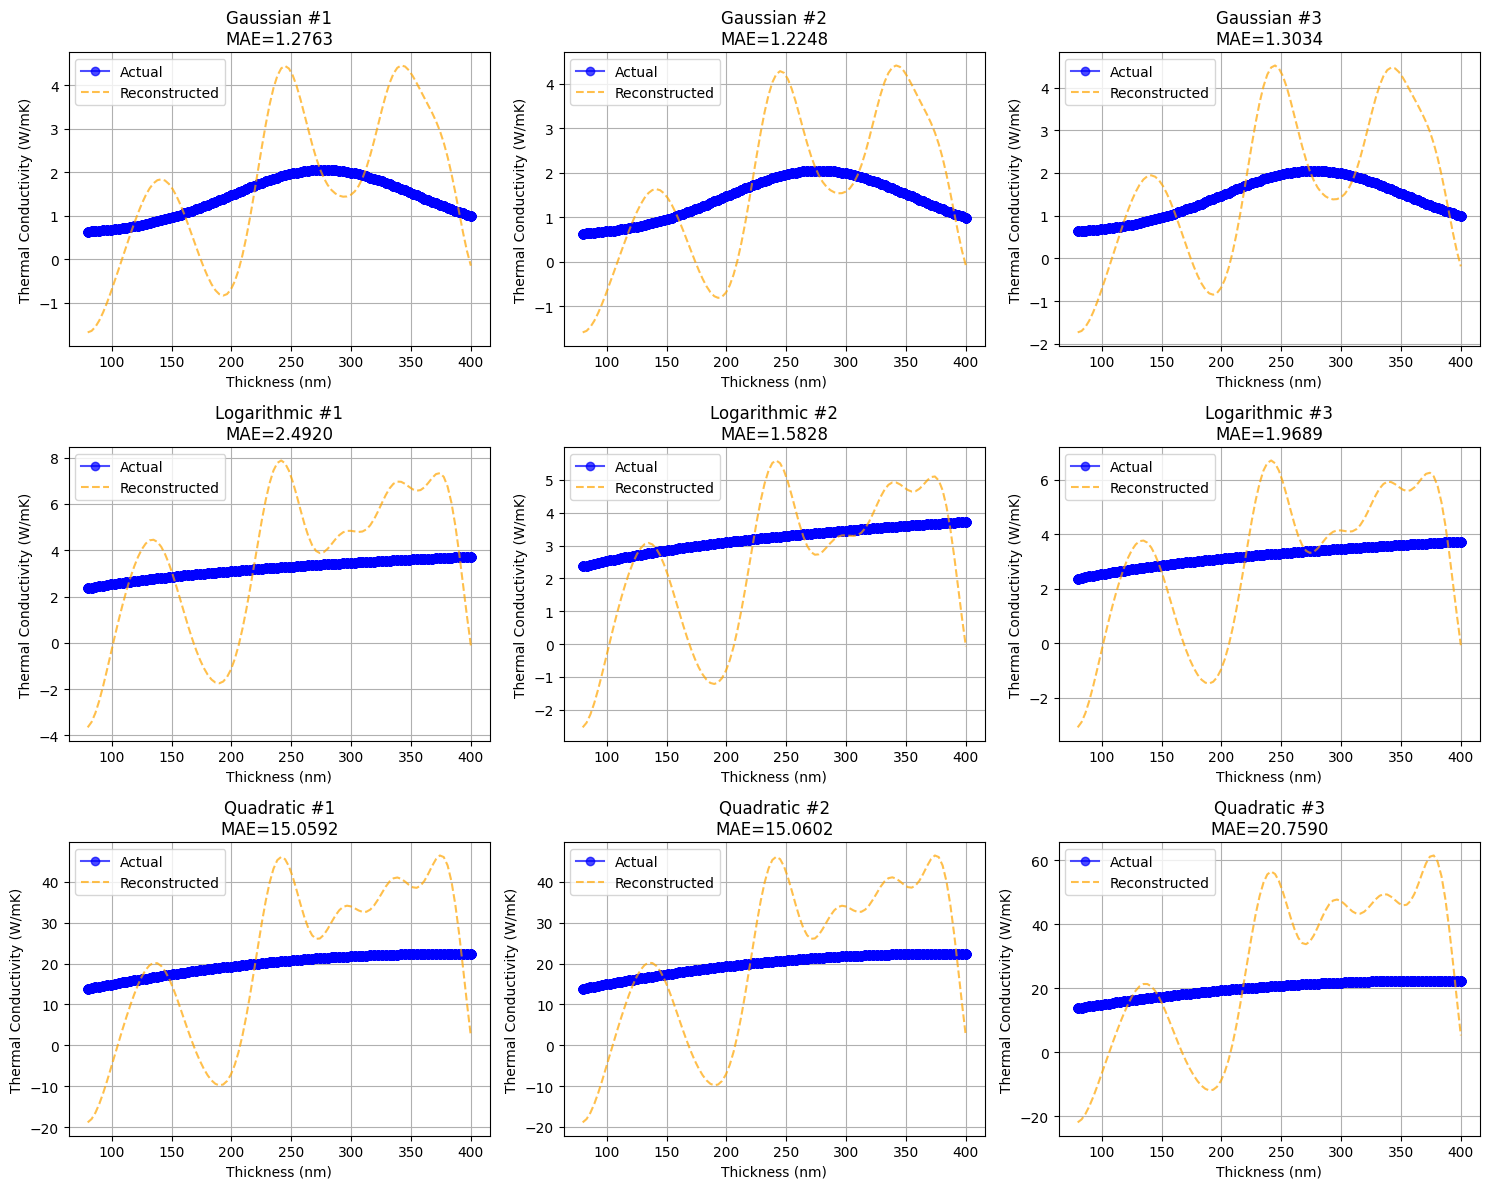


MAE Summary:
Gaussian: Mean MAE = 1.2682, Min = 1.2248, Max = 1.3034
Logarithmic: Mean MAE = 2.0146, Min = 1.5828, Max = 2.4920
Quadratic: Mean MAE = 16.9595, Min = 15.0592, Max = 20.7590


{'gaussian': [1.2762908339214398, 1.224815872433873, 1.3034278164974846],
 'logarithmic': [2.492013932832014, 1.5828130465561987, 1.9689156311282723],
 'quadratic': [15.059246378176407, 15.060153907381528, 20.759045945655156]}

In [3]:
# Load the saved model and visualize multiple predictions
def visualize_saved_model(model_path='models/best_model_N20_Complex.pth', samples_per_type=5):
    # Load data files
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=20)
    
    # Data Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Load model
    model = FourierNN(input_dim=3, output_dim=42)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"Model loaded from {model_path}")
    
    # Visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=15)
            
            # Calculate MAE
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N20_complex.png', dpi=300)
    plt.show()
    
    # Print summary of MAE values
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    return mae_values

# Call the function to visualize multiple examples
visualize_saved_model(model_path='models/best_model_N20_Complex.pth', samples_per_type=3)


Starting improved thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting model training...
Epoch 1/100: Train Loss = 0.797945, Val Loss = 0.790459
Saved best model (Val Loss: 0.790459)
Epoch 2/100: Train Loss = 0.792968, Val Loss = 0.789568
Saved best model (Val Loss: 0.789568)
Epoch 3/100: Train Loss = 0.792329, Val Loss = 0.789114
Saved best model (Val Loss: 0.789114)
Epoch 4/100: Train Loss = 0.792074, Val Loss = 0.789210
Epoch 5/100: Train Loss = 0.791890, Val Loss = 0.788837
Saved best model (Val Loss: 0.788837)
Epoch 6/100: Train Loss = 0.791721, Val Loss = 0.788690
Saved best model (Val Loss: 0.788690)
Epoch 7/100: Train Loss = 0.791588, Val Loss = 0.788530
Saved best model (Val Loss: 0.788530)
Epoch 8/100: Train Loss = 0.791483, Val Loss = 0.789474
Epoch 9/100: Train Loss = 0.791352, Val Loss = 0.788409
Saved best model (Val Loss: 0.788409)
Epoch 10/100: Train Loss = 0.791306, Val Loss = 0.788175
Saved best model (Val Loss: 0.788175)
Epoch 11/100: Train Loss = 0.791246, Val Loss = 0.788276
Epoch 12/100: Train Loss = 0.791166, Val Loss = 0.7

/tmp/ipykernel_7043/3985952424.py:383: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{model_filename}'))


Evaluating model and generating visualizations...

MAE Summary:
Gaussian: Mean MAE = 3.6559, Min = 3.6423, Max = 3.6666
Logarithmic: Mean MAE = 3.8332, Min = 3.7626, Max = 3.9099
Quadratic: Mean MAE = 8.2434, Min = 8.0903, Max = 8.3224

MAPE Summary (%):
Gaussian: Mean MAPE = 247.29%, Min = 246.87%, Max = 247.90%
Logarithmic: Mean MAPE = 117.62%, Min = 115.16%, Max = 120.29%
Quadratic: Mean MAPE = 45.49%, Min = 45.02%, Max = 45.74%
Analysis completed in 5195.74 seconds
Model saved as: models/20250415_N15.pth
Visualizations saved to 'visualizations/profiles_20250415_N15.png'


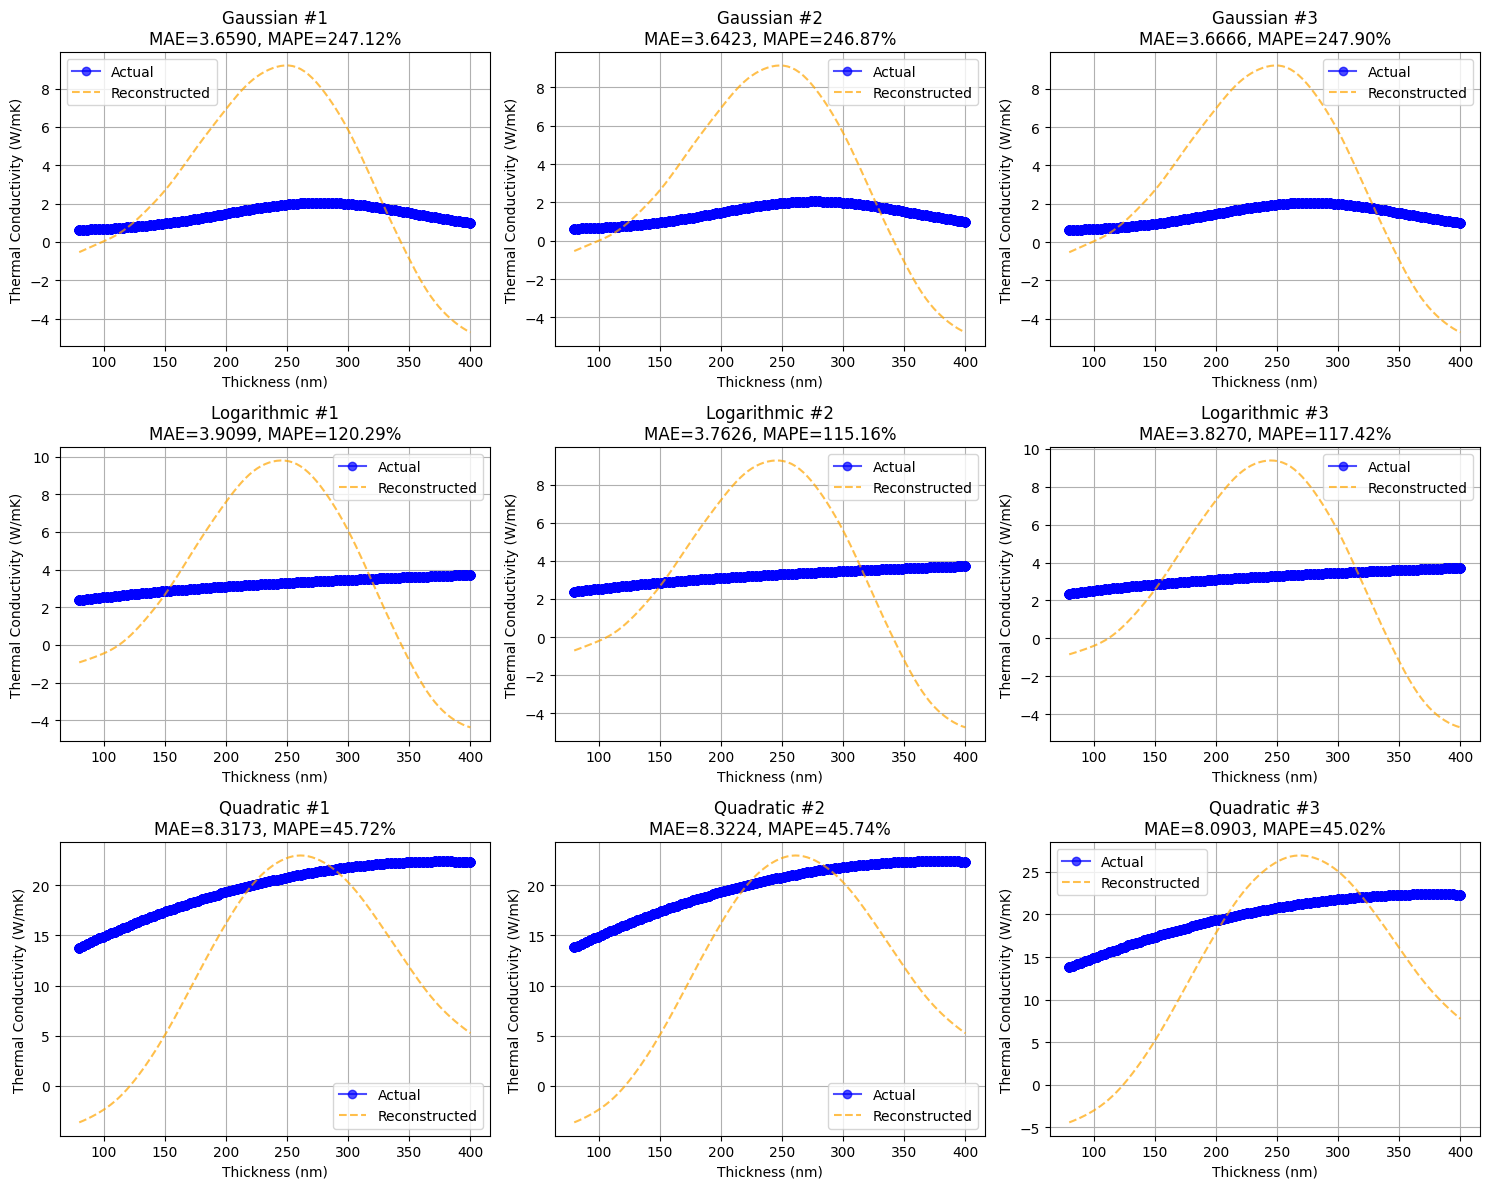

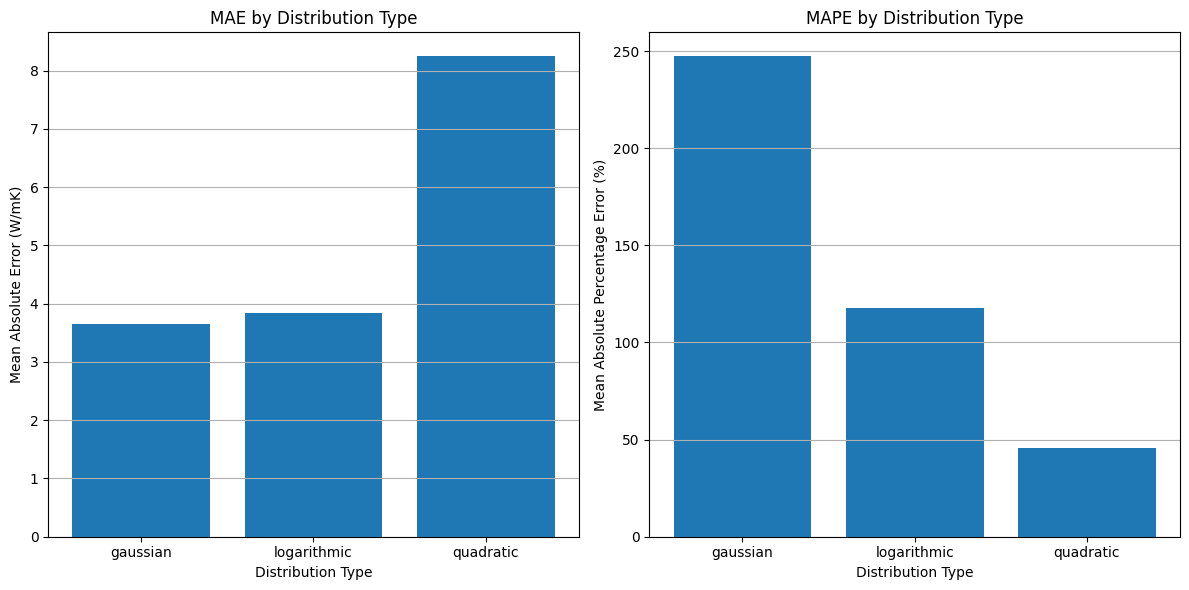

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os
from datetime import datetime

# =============================
# 1. Fourier Series Processing with Windowing and Sampling Rate Improvements
# =============================

def fourier_series_coefficients(y_values, x_values, N=15, window_type='hann'):
    """Convert a distribution into Fourier series coefficients with windowing to reduce Gibbs phenomenon."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")
    
    # Apply windowing function to reduce oscillations
    if window_type == 'hann':
        window = 0.5 * (1 - np.cos(2 * np.pi * np.arange(len(y_values)) / (len(y_values) - 1)))
    elif window_type == 'hamming':
        window = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(len(y_values)) / (len(y_values) - 1))
    else:
        window = np.ones_like(y_values)  # No windowing
    
    # Apply window to y_values
    y_windowed = y_values * window
    
    a0 = np.mean(y_windowed)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_windowed * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_windowed * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile with Lanczos sigma approximation to reduce oscillations."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]
    
    # Initialize with a0/2
    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)
    
    # Apply Lanczos sigma approximation to reduce Gibbs phenomenon
    for n in range(1, N+1):
        # Lanczos sigma factor
        sigma = np.sin(np.pi * n / N) / (np.pi * n / N) if n < N else 1.0
        
        reconstructed_profile += sigma * (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )
    
    return reconstructed_profile

# =============================
# 2. Data Processing with Feature Engineering
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients with distribution-specific handling."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}
        
        # Use appropriate window type based on distribution type
        window_type = 'hann' if eq_type in ['quadratic', 'logarithmic'] else None

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation with window
            coeffs = fourier_series_coefficients(y_values, x_values, N=N, window_type=window_type)

            # Create a row for each x value with enhanced features
            for i in range(len(x_values)):
                # Enhanced features including normalized position and polynomial terms
                x_norm = (x_values[i] - x_values[0]) / (x_values[-1] - x_values[0]) if (x_values[-1] - x_values[0]) != 0 else 0
                x_squared = (x_values[i]/100)**2  # Scaled to avoid large values
                x_cubed = (x_values[i]/100)**3  # Scaled to avoid large values
                
                features_list.append([
                    x_values[i],  # Original thickness
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i],
                    x_norm,  # Normalized position in [0,1]
                    x_squared,  # Quadratic term
                    x_cubed  # Cubic term
                ])
                
                # Target includes Fourier coefficients and actual thermal conductivity
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, 
                              columns=['x', 'ModelRatio', 'TimeDelay', 'x_norm', 'x_squared', 'x_cubed'])
    
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Improved Neural Network with Residual Connections
# =============================

class EnhancedFourierNN(nn.Module):
    """Enhanced neural network with residual connections and advanced architecture"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        
        # First block with input layer
        self.input_block = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.SiLU(),  # SiLU (Swish) activation function
            nn.BatchNorm1d(128),
            nn.Dropout(0.1)
        )
        
        # Residual block 1
        self.res_block1 = nn.Sequential(
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1)
        )
        
        # Middle layer
        self.middle = nn.Sequential(
            nn.Linear(128, 256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        
        # Residual block 2
        self.res_block2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        
        # Output layers
        self.output_block = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        # Input block
        x1 = self.input_block(x)
        
        # Residual block 1
        res1 = self.res_block1(x1)
        x2 = x1 + res1  # Residual connection
        
        # Middle layer
        x3 = self.middle(x2)
        
        # Residual block 2
        res2 = self.res_block2(x3)
        x4 = x3 + res2  # Residual connection
        
        # Output block
        out = self.output_block(x4)
        
        return out

# =============================
# 5. Custom Loss Function
# =============================

class FourierSmoothingLoss(nn.Module):
    """Custom loss function that penalizes high-frequency oscillations"""
    def __init__(self, smoothness_weight=0.1, boundary_weight=0.2, N=15):
        super().__init__()
        self.mse = nn.MSELoss()
        self.smoothness_weight = smoothness_weight
        self.boundary_weight = boundary_weight
        self.N = N
        
    def forward(self, pred, target):
        # Standard MSE loss
        base_loss = self.mse(pred, target)
        
        # Smoothness penalty on high-frequency Fourier coefficients
        fourier_coeffs = pred[:, 1:2*self.N+1]  # All Fourier coefficients (excluding a0)
        
        # Create weights that increase with frequency
        freq_weights = torch.arange(1, 2*self.N+1, device=fourier_coeffs.device).float()
        freq_weights = freq_weights ** 1.5  # Higher power for more aggressive penalization
        
        smoothness_loss = torch.mean(freq_weights * fourier_coeffs.pow(2))
        
        # Combined loss with weighted smoothing term
        total_loss = base_loss + self.smoothness_weight * smoothness_loss
        
        return total_loss

# =============================
# 6. Training and Evaluation Function
# =============================

def train_and_evaluate():
    start_time = time.time()
    print("Starting improved thermal conductivity profile analysis...")
    
    # Get current date for model naming
    current_date = datetime.now().strftime("%Y%m%d")
    N = 15  # Fourier series terms
    
    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)
    
    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data with enhanced features
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)
    
    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets with stratification
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128)

    # Initialize enhanced model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = EnhancedFourierNN(input_dim=input_dim, output_dim=output_dim)
    
    # Training parameters with custom loss
    criterion = FourierSmoothingLoss(smoothness_weight=0.15, boundary_weight=0.2, N=N)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.002, weight_decay=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 100
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            total_loss += loss_batch.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
        
        # Learning rate scheduler step
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save model
            model_filename = f"{current_date}_N{N}.pth"
            torch.save(model.state_dict(), f'models/{model_filename}')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
    
    # Load best model
    model_filename = f"{current_date}_N{N}.pth"
    model.load_state_dict(torch.load(f'models/{model_filename}'))
    
    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (N={N})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'visualizations/loss_curve_{current_date}_N{N}.png', dpi=300)
    plt.close()
    
    # Evaluation and Visualization with MAPE calculation
    print("Evaluating model and generating visualizations...")
    model.eval()
    
    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    fig, axes = plt.subplots(len(eq_types), 3, figsize=(15, 12))
    
    # Store error metrics
    mae_values = {eq_type: [] for eq_type in eq_types}
    mape_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select up to 3 samples
        selected_indices = eq_indices[:3]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile with Lanczos sigma approximation
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
            
            # Calculate error metrics
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Calculate MAPE (Mean Absolute Percentage Error)
            epsilon = 1e-10  # Small value to avoid division by zero
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values[eq_type].append(mape)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label='Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label='Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/profiles_{current_date}_N{N}.png', dpi=300)
    
    # Print summary of error metrics
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    print("\nMAPE Summary (%):")
    for eq_type, mapes in mape_values.items():
        print(f"{eq_type.capitalize()}: Mean MAPE = {np.mean(mapes):.2f}%, Min = {np.min(mapes):.2f}%, Max = {np.max(mapes):.2f}%")
    
    # Create comparison plot for error metrics
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(eq_types, [np.mean(mae_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Error (W/mK)')
    plt.title('MAE by Distribution Type')
    plt.grid(axis='y')
    
    plt.subplot(1, 2, 2)
    plt.bar(eq_types, [np.mean(mape_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.title('MAPE by Distribution Type')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/error_metrics_{current_date}_N{N}.png', dpi=300)
    
    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print(f"Model saved as: models/{model_filename}")
    print(f"Visualizations saved to 'visualizations/profiles_{current_date}_N{N}.png'")

# Run the complete analysis
if __name__ == "__main__":
    train_and_evaluate()


Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples
Starting model training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.085838, Val Loss = 0.073895
Saved best model (Val Loss: 0.073895)
Epoch 2/50: Train Loss = 0.077236, Val Loss = 0.076169
Epoch 3/50: Train Loss = 0.076194, Val Loss = 0.047785
Saved best model (Val Loss: 0.047785)
Epoch 4/50: Train Loss = 0.075875, Val Loss = 0.082348
Epoch 5/50: Train Loss = 0.075386, Val Loss = 0.061225
Epoch 6/50: Train Loss = 0.075023, Val Loss = 0.060744
Epoch 7/50: Train Loss = 0.074844, Val Loss = 0.056010
Epoch 8/50: Train Loss = 0.074308, Val Loss = 0.068941
Epoch 9/50: Train Loss = 0.074018, Val Loss = 0.064627
Epoch 10/50: Train Loss = 0.073116, Val Loss = 0.062841
Epoch 11/50: Train Loss = 0.072429, Val Loss = 0.058255
Epoch 12/50: Train Loss = 0.072114, Val Loss = 0.061952
Epoch 13/50: Train Loss = 0.072007, Val Loss = 0.054661
Early stopping triggered at epoch 13


/tmp/ipykernel_10044/286874640.py:284: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model_n15_Apr.pth'))


Evaluating model and generating visualizations...
Analysis completed in 1430.73 seconds
Visualizations saved to 'visualizations/thermal_conductivity_profiles_N15_15Apr.png'

MAE Summary:
Gaussian: Mean MAE = 1.6152, Min = 1.5236, Max = 1.6686
Logarithmic: Mean MAE = 1.8269, Min = 1.0741, Max = 2.5896
Quadratic: Mean MAE = 9.9299, Min = 7.8401, Max = 13.9805

MAPE Summary (%):
Gaussian: Mean MAPE = 118.57%, Min = 110.61%, Max = 123.04%
Logarithmic: Mean MAPE = 56.70%, Min = 33.22%, Max = 80.58%
Quadratic: Mean MAPE = 47.19%, Min = 37.38%, Max = 66.19%


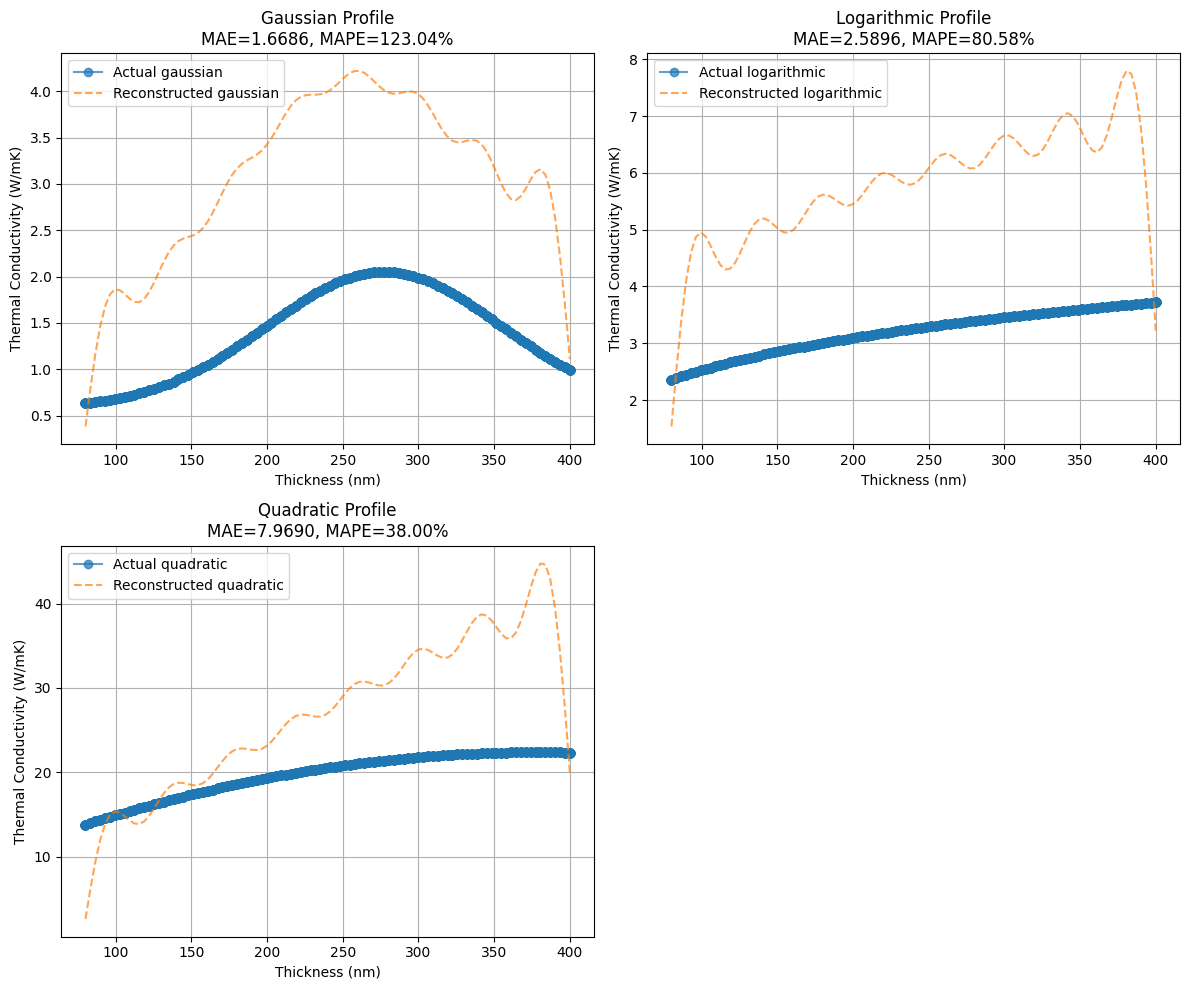

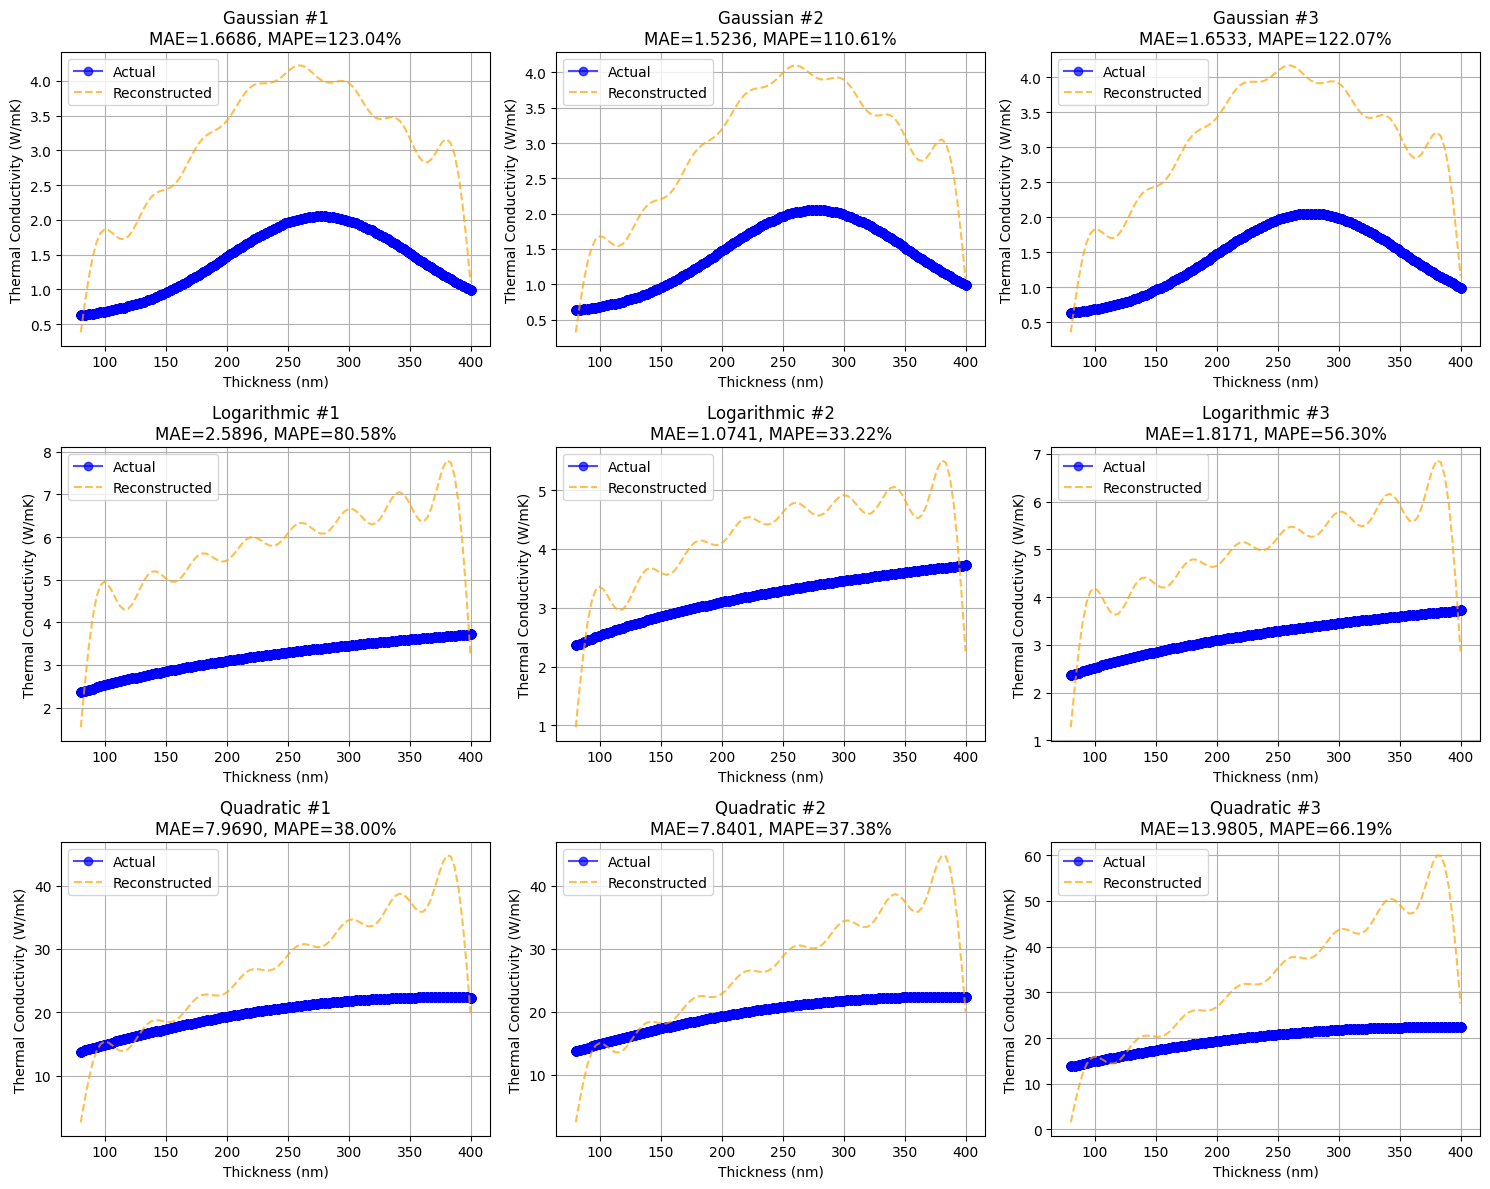

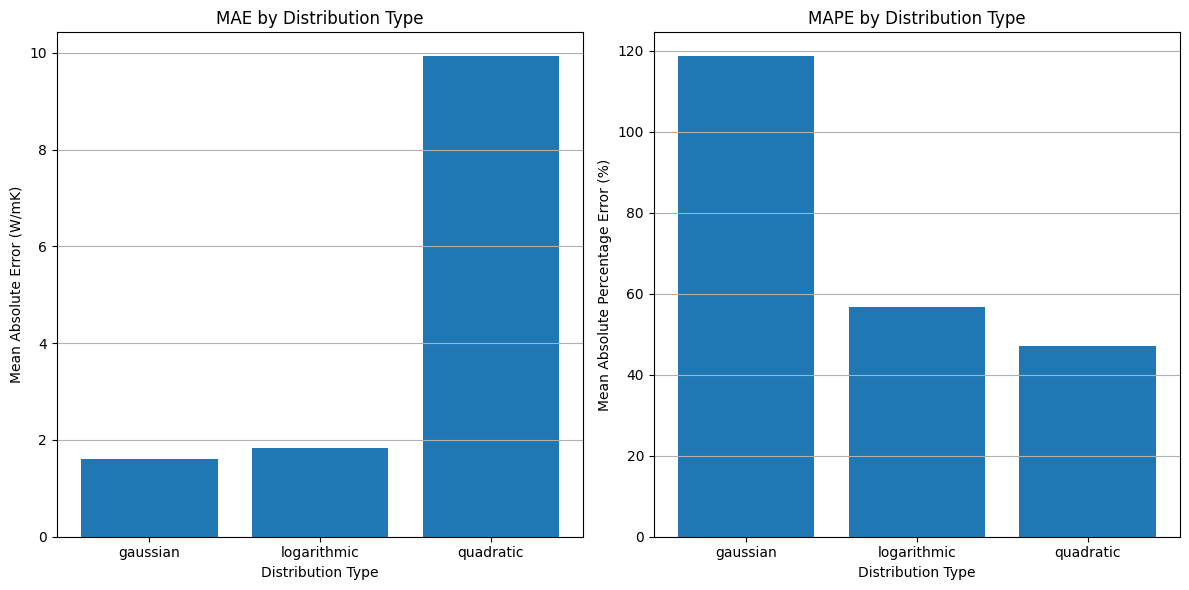

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definitions
# =============================

class FourierNN(nn.Module):
    """Standard ReLU model with dropout"""
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            # Input layer
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            
            # First hidden layer
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            
            # Second hidden layer
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15),
            
            # Third hidden layer
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            
            # Output layer
            nn.Linear(128, output_dim)
        )
        self.name = "ReLU_Standard"
    
    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Parameters
    N = 15  # Fourier series terms

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = FourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'models/best_model_n15_Apr.pth')
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load('models/best_model_n15_Apr.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve.png', dpi=300)
    plt.close()

    # Evaluation and Visualization
    print("Evaluating model and generating visualizations...")
    model.eval()

    # Sample examples from each distribution type for visualization
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        # Get a sample from this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]

        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
            
        # Take the first sample
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        # Get reference profile
        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_values = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        # Predict Fourier coefficients
        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]

        # Inverse transform prediction
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]

        # Reconstruct profile
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)

        # Calculate MAE
        mae = mean_absolute_error(y_actual, y_reconstructed)

        # Calculate MAPE
        epsilon = 1e-10  # Small value to avoid division by zero
        mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100

        # Plot
        plt.subplot(2, 2, i+1)
        plt.plot(x_values, y_actual, 'o-', label=f'Actual {eq_type}', alpha=0.7)
        plt.plot(x_values, y_reconstructed, '--', label=f'Reconstructed {eq_type}', alpha=0.7)
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} Profile\nMAE={mae:.4f}, MAPE={mape:.2f}%')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/thermal_conductivity_profiles_N15_15Apr.png', dpi=300)

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")
    print("Visualizations saved to 'visualizations/thermal_conductivity_profiles_N15_15Apr.png'")

    # Create visualization showing multiple examples per distribution type
    visualize_multiple_examples(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, N=15)

if __name__ == "__main__":
    main()

# =============================
# 7. Multiple Examples Visualization
# =============================

def visualize_multiple_examples(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, N=15, samples_per_type=3):
    """
    Visualize multiple examples for each distribution type
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        target_scaler: Scaler for inverse transforming predictions
        reference_profiles: Dictionary of reference profiles
        eq_test: List of equation types for test samples
        X_test: Test features
        N: Number of Fourier terms
        samples_per_type: Number of examples to visualize per distribution type
    """
    model.eval()
    eq_types = list(reference_profiles.keys())
    
    # Create a figure with subplots for each distribution type
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    mape_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
            
            # Calculate error metrics
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Calculate MAPE
            epsilon = 1e-10  # Small value to avoid division by zero
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values[eq_type].append(mape)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N{N}.png', dpi=300)
    
    # Print summary of error metrics
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    print("\nMAPE Summary (%):")
    for eq_type, mapes in mape_values.items():
        print(f"{eq_type.capitalize()}: Mean MAPE = {np.mean(mapes):.2f}%, Min = {np.min(mapes):.2f}%, Max = {np.max(mapes):.2f}%")
    
    # Create comparative visualization for error metrics
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(eq_types, [np.mean(mae_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Error (W/mK)')
    plt.title('MAE by Distribution Type')
    plt.grid(axis='y')
    
    plt.subplot(1, 2, 2)
    plt.bar(eq_types, [np.mean(mape_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.title('MAPE by Distribution Type')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/error_metrics_N{N}.png', dpi=300)
    plt.show()
    
    return mae_values, mape_values


In [3]:

def visualize_multiple_examples(model, test_loader, target_scaler, reference_profiles, eq_test, X_test, N=15, samples_per_type=3):
    """
    Visualize multiple examples for each distribution type
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        target_scaler: Scaler for inverse transforming predictions
        reference_profiles: Dictionary of reference profiles
        eq_test: List of equation types for test samples
        X_test: Test features
        N: Number of Fourier terms
        samples_per_type: Number of examples to visualize per distribution type
    """
    model.eval()
    eq_types = list(reference_profiles.keys())
    
    # Create a figure with subplots for each distribution type
    fig, axes = plt.subplots(len(eq_types), samples_per_type, figsize=(5*samples_per_type, 4*len(eq_types)))
    
    # If only one distribution type, make axes 2D
    if len(eq_types) == 1:
        axes = axes.reshape(1, -1)
    
    # Store MAE values for reporting
    mae_values = {eq_type: [] for eq_type in eq_types}
    mape_values = {eq_type: [] for eq_type in eq_types}
    
    for i, eq_type in enumerate(eq_types):
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select samples_per_type samples or all available if fewer
        selected_indices = eq_indices[:samples_per_type]
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
            
            # Calculate error metrics
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values[eq_type].append(mae)
            
            # Calculate MAPE
            epsilon = 1e-10  # Small value to avoid division by zero
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values[eq_type].append(mape)
            
            # Plot
            ax = axes[i, j]
            ax.plot(x_values, y_actual, 'o-', label=f'Actual', color='blue', alpha=0.7)
            ax.plot(x_values, y_reconstructed, '--', label=f'Reconstructed', color='orange', alpha=0.7)
            ax.set_xlabel('Thickness (nm)')
            ax.set_ylabel('Thermal Conductivity (W/mK)')
            ax.set_title(f'{eq_type.capitalize()} #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'visualizations/multiple_examples_N{N}.png', dpi=300)
    
    # Print summary of error metrics
    print("\nMAE Summary:")
    for eq_type, maes in mae_values.items():
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(maes):.4f}, Min = {np.min(maes):.4f}, Max = {np.max(maes):.4f}")
    
    print("\nMAPE Summary (%):")
    for eq_type, mapes in mape_values.items():
        print(f"{eq_type.capitalize()}: Mean MAPE = {np.mean(mapes):.2f}%, Min = {np.min(mapes):.2f}%, Max = {np.max(mapes):.2f}%")
    
    # Create comparative visualization for error metrics
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(eq_types, [np.mean(mae_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Error (W/mK)')
    plt.title('MAE by Distribution Type')
    plt.grid(axis='y')
    
    plt.subplot(1, 2, 2)
    plt.bar(eq_types, [np.mean(mape_values[eq_type]) for eq_type in eq_types])
    plt.xlabel('Distribution Type')
    plt.ylabel('Mean Absolute Percentage Error (%)')
    plt.title('MAPE by Distribution Type')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/error_metrics_N{N}.png', dpi=300)
    plt.show()
    
    return mae_values, mape_values


Starting thermal conductivity profile analysis with N=15...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Normalizing data...
Splitting data into train/test sets...
Training set: 1392400 samples
Test set: 348100 samples
Starting model training...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.013918, Val Loss = 0.008461
Saved best model (Val Loss: 0.008461)
Epoch 2/50: Train Loss = 0.010044, Val Loss = 0.008587
Epoch 3/50: Train Loss = 0.009547, Val Loss = 0.008046
Saved best model (Val Loss: 0.008046)
Epoch 4/50: Train Loss = 0.009438, Val Loss = 0.007672
Saved best model (Val Loss: 0.007672)
Epoch 5/50: Train Loss = 0.009317, Val Loss = 0.007441
Saved best model (Val Loss: 0.007441)
Epoch 6/50: Train Loss = 0.009263, Val Loss = 0.009322
Epoch 7/50: Train Loss = 0.009221, Val Loss = 0.007385
Saved best model (Val Loss: 0.007385)
Epoch 8/50: Train Loss = 0.009183, Val Loss = 0.007820
Epoch 9/50: Train Loss = 0.009164, Val Loss = 0.008922
Epoch 10/50: Train Loss = 0.009145, Val Loss = 0.007266
Saved best model (Val Loss: 0.007266)
Epoch 11/50: Train Loss = 0.009121, Val Loss = 0.007895
Epoch 12/50: Train Loss = 0.009091, Val Loss = 0.007245
Saved best model (Val Loss: 0.007245)
Epoch 13/50: Train Loss = 0.009080, Val Loss = 0.007718
Epoch 14/50: Tr

/tmp/ipykernel_10044/3218217849.py:326: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/simple_model_N{N}.pth'))



Gaussian Summary:
Mean MAE = 0.8947, Min = 0.5832, Max = 1.1934
Mean MAPE = 57.42%, Min = 33.13%, Max = 80.45%

Logarithmic Summary:
Mean MAE = 1.9700, Min = 1.7639, Max = 2.2086
Mean MAPE = 71.08%, Min = 63.66%, Max = 79.64%

Quadratic Summary:
Mean MAE = 10.1754, Min = 8.3924, Max = 13.6846
Mean MAPE = 33.59%, Min = 28.79%, Max = 43.02%

Overall Summary:
Gaussian: Mean MAE = 0.9662, Mean MAPE = 63.30%
Logarithmic: Mean MAE = 1.5702, Mean MAPE = 56.57%
Quadratic: Mean MAE = 7.7506, Mean MAPE = 25.61%
Analysis completed in 933.72 seconds


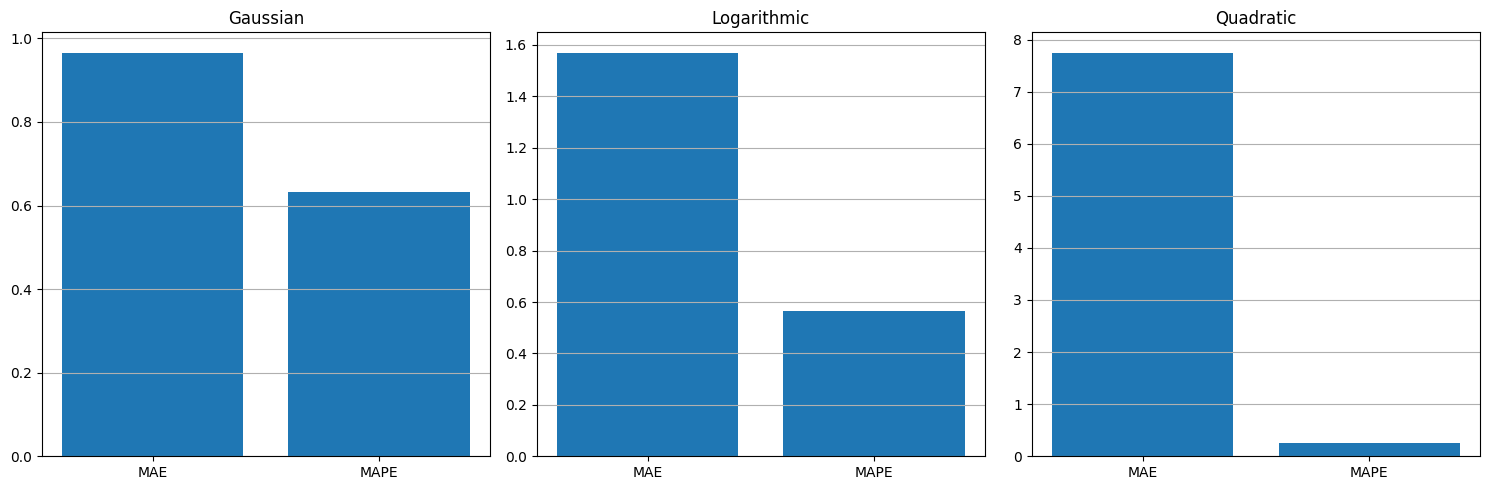

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing with Distribution-Specific Parameters
# =============================

def fourier_series_coefficients(y_values, x_values, N=15, distribution_type=None):
    """
    Convert a distribution into Fourier series coefficients with distribution-specific handling.
    
    Args:
        y_values: Thermal conductivity values
        x_values: Thickness values
        N: Number of Fourier terms
        distribution_type: Type of distribution ('gaussian', 'logarithmic', 'quadratic')
    
    Returns:
        coeffs: List of Fourier coefficients [a0, a1, ..., an, b1, ..., bn]
    """
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")
    
    # Handle different distribution types differently
    if distribution_type == 'quadratic':
        # For quadratic, normalize y values to reduce high absolute values
        y_max = np.max(y_values)
        y_normalized = y_values / y_max if y_max != 0 else y_values
        a0 = np.mean(y_normalized) * y_max  # Scale back after calculation
        a_coeffs, b_coeffs = [], []
        
        for n in range(1, N+1):
            cos_term = np.cos(n * np.pi * x_values / L)
            sin_term = np.sin(n * np.pi * x_values / L)
            an = (2 / len(x_values)) * np.sum(y_normalized * cos_term) * y_max
            bn = (2 / len(x_values)) * np.sum(y_normalized * sin_term) * y_max
            a_coeffs.append(an)
            b_coeffs.append(bn)
    else:
        # Standard approach for gaussian and logarithmic
        a0 = np.mean(y_values)
        a_coeffs, b_coeffs = [], []
        
        for n in range(1, N+1):
            cos_term = np.cos(n * np.pi * x_values / L)
            sin_term = np.sin(n * np.pi * x_values / L)
            an = (2 / len(x_values)) * np.sum(y_values * cos_term)
            bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
            a_coeffs.append(an)
            b_coeffs.append(bn)
    
    return [a0] + a_coeffs + b_coeffs

def reconstruct_profile(coeffs_predicted, x_values, N=15, distribution_type=None):
    """
    Reconstructs conductivity profile from Fourier coefficients with distribution-specific handling.
    
    Args:
        coeffs_predicted: Predicted Fourier coefficients
        x_values: Thickness values
        N: Number of Fourier terms
        distribution_type: Type of distribution ('gaussian', 'logarithmic', 'quadratic')
    
    Returns:
        reconstructed_profile: Reconstructed thermal conductivity profile
    """
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")
    
    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:2*N+1]
    
    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)
    
    for n in range(1, N+1):
        # Apply coefficient damping for higher frequencies to reduce oscillations
        # More aggressive damping for quadratic profiles which show more oscillations
        if distribution_type == 'quadratic':
            damping = 1.0 / (1.0 + 0.1 * n)
        else:
            damping = 1.0 / (1.0 + 0.05 * n)
            
        reconstructed_profile += damping * (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )
    
    # Ensure non-negative values for thermal conductivity
    reconstructed_profile = np.maximum(reconstructed_profile, 0)
    
    return reconstructed_profile

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients with distribution-specific handling."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        # Process a subset of equations to reduce dataset size and training time
        unique_equations = df['Equation_ID'].unique()
        selected_equations = np.random.choice(unique_equations, size=min(100, len(unique_equations)), replace=False)
        
        for eq_id in selected_equations:
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients with distribution-specific handling
            coeffs = fourier_series_coefficients(y_values, x_values, N=N, distribution_type=eq_type)

            # Create a row for each x value with basic feature engineering
            for i in range(len(x_values)):
                # Calculate normalized position
                norm_pos = (x_values[i] - x_values[0]) / (x_values[-1] - x_values[0]) if x_values[-1] != x_values[0] else 0.5
                
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i],
                    norm_pos  # Add normalized position as a feature
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay', 'NormPos'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Simplified Model Architecture
# =============================

class SimpleFourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        # Simpler architecture with fewer layers and parameters
        self.network = nn.Sequential(
            # Input layer
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            
            # Hidden layer 1
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            
            # Hidden layer 2
            nn.Linear(128, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            
            # Output layer
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)

# =============================
# 5. Thermal Conductivity Analysis
# =============================

def analyze_thermal_conductivity(N=15, use_subset=True):
    start_time = time.time()
    print(f"Starting thermal conductivity profile analysis with N={N}...")

    # Create directories for output
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Load Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    # Data Normalization
    print("Normalizing data...")
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    # Use MinMaxScaler for targets to preserve relative scaling
    target_scaler = MinMaxScaler(feature_range=(-1, 1))
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    # Split into training and testing sets with stratification
    print("Splitting data into train/test sets...")
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")

    # Create datasets and dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128)

    # Initialize model
    input_dim = X_train.shape[1]  # Number of input features
    output_dim = y_train.shape[1]  # Number of output dimensions
    model = SimpleFourierNN(input_dim=input_dim, output_dim=output_dim)

    # Training parameters
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add small weight decay
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Training with early stopping
    print("Starting model training...")
    best_loss = float('inf')
    patience = 10
    counter = 0
    epochs = 50
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                loss_batch = criterion(outputs_batch, targets_batch)
                val_loss += loss_batch.item()
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            # Save best model
            torch.save(model.state_dict(), f'models/simple_model_N{N}.pth', _use_new_zipfile_serialization=False)
            print(f"Saved best model (Val Loss: {avg_val_loss:.6f})")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load(f'models/simple_model_N{N}.pth'))

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (N={N})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'visualizations/loss_curve_N{N}.png', dpi=300)
    plt.close()

    # Evaluate and visualize by distribution type
    visualize_results_by_type(model, target_scaler, reference_profiles, eq_test, X_test, N)
    
    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")

def visualize_results_by_type(model, target_scaler, reference_profiles, eq_test, X_test, N=15, samples_per_type=3):
    """Visualize results separately for each distribution type."""
    model.eval()
    eq_types = list(reference_profiles.keys())
    
    # Create figures for each distribution type
    for eq_type in eq_types:
        plt.figure(figsize=(15, 6))
        plt.suptitle(f'{eq_type.capitalize()} Distribution Results', fontsize=16)
        
        # Get samples for this distribution type
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        # Select up to samples_per_type samples
        selected_indices = eq_indices[:samples_per_type]
        mae_values = []
        mape_values = []
        
        for j, sample_idx in enumerate(selected_indices):
            # Get sample features
            sample_features = X_test[sample_idx]
            
            # Get reference profile
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            # Predict Fourier coefficients
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            # Inverse transform prediction
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            
            # Reconstruct profile with distribution-specific handling
            y_reconstructed = reconstruct_profile(
                prediction_original[:-1], 
                x_values, 
                N=N, 
                distribution_type=eq_type
            )
            
            # Calculate error metrics
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mae_values.append(mae)
            
            # Calculate MAPE
            epsilon = 1e-10  # Small value to avoid division by zero
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            mape_values.append(mape)
            
            # Plot
            plt.subplot(1, samples_per_type, j+1)
            plt.plot(x_values, y_actual, 'o-', label='Actual', color='blue', alpha=0.7)
            plt.plot(x_values, y_reconstructed, '--', label='Reconstructed', color='orange', alpha=0.7)
            plt.xlabel('Thickness (nm)')
            plt.ylabel('Thermal Conductivity (W/mK)')
            plt.title(f'Sample #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f'visualizations/{eq_type}_profiles_N{N}.png', dpi=300)
        plt.close()
        
        # Print summary for this distribution type
        print(f"\n{eq_type.capitalize()} Summary:")
        print(f"Mean MAE = {np.mean(mae_values):.4f}, Min = {np.min(mae_values):.4f}, Max = {np.max(mae_values):.4f}")
        print(f"Mean MAPE = {np.mean(mape_values):.2f}%, Min = {np.min(mape_values):.2f}%, Max = {np.max(mape_values):.2f}%")
    
    # Create a summary visualization
    fig, axes = plt.subplots(1, len(eq_types), figsize=(15, 5))
    all_mae = {eq_type: [] for eq_type in eq_types}
    all_mape = {eq_type: [] for eq_type in eq_types}
    
    # Calculate metrics for more samples
    for eq_type in eq_types:
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        selected_indices = eq_indices[:10]  # Use more samples for statistics
        
        for sample_idx in selected_indices:
            sample_features = X_test[sample_idx]
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            y_reconstructed = reconstruct_profile(
                prediction_original[:-1], 
                x_values, 
                N=N, 
                distribution_type=eq_type
            )
            
            mae = mean_absolute_error(y_actual, y_reconstructed)
            all_mae[eq_type].append(mae)
            
            epsilon = 1e-10
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + epsilon))) * 100
            all_mape[eq_type].append(mape)
    
    # Plot summary
    for i, eq_type in enumerate(eq_types):
        axes[i].bar([0, 1], [np.mean(all_mae[eq_type]), np.mean(all_mape[eq_type]) / 100])
        axes[i].set_title(f'{eq_type.capitalize()}')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['MAE', 'MAPE'])
        axes[i].grid(axis='y')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/summary_metrics_N{N}.png', dpi=300)
    
    # Print overall summary
    print("\nOverall Summary:")
    for eq_type in eq_types:
        print(f"{eq_type.capitalize()}: Mean MAE = {np.mean(all_mae[eq_type]):.4f}, Mean MAPE = {np.mean(all_mape[eq_type]):.2f}%")

# =============================
# 6. Main Execution
# =============================

if __name__ == "__main__":
    analyze_thermal_conductivity(N=15)


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Convert a distribution into Fourier series coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0 = np.mean(y_values)  # Constant term
    a_coeffs, b_coeffs = [], []

    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x_values / L)
        sin_term = np.sin(n * np.pi * x_values / L)
        an = (2 / len(x_values)) * np.sum(y_values * cos_term)
        bn = (2 / len(x_values)) * np.sum(y_values * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    """Process all distributions into Fourier coefficients."""
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            # Sort by thickness for consistency
            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            # Store reference profile for later visualization
            if eq_id not in reference_profiles[eq_type]:
                reference_profiles[eq_type][eq_id] = {
                    'x': x_values,
                    'y': y_values
                }

            # Calculate Fourier coefficients once per equation
            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            # Create a row for each x value
            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(
        targets_list,
        columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity']
    )

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definition
# =============================

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    """Reconstructs conductivity profile from Fourier coefficients."""
    L = x_values[-1] - x_values[0]
    if L == 0:
        raise ValueError("Period length L cannot be zero.")

    a0_predicted = coeffs_predicted[0]
    a_coeffs_predicted = coeffs_predicted[1:N+1]
    b_coeffs_predicted = coeffs_predicted[N+1:]

    reconstructed_profile = np.ones_like(x_values) * (a0_predicted / 2)

    for n in range(1, N+1):
        reconstructed_profile += (
            a_coeffs_predicted[n-1] * np.cos(n * np.pi * x_values / L) +
            b_coeffs_predicted[n-1] * np.sin(n * np.pi * x_values / L)
        )

    return reconstructed_profile

# =============================
# 6. Enhanced Visualization
# =============================

def enhanced_visualization(model, target_scaler, reference_profiles, eq_test, X_test, N=15, samples_per_type=3):
    """Generate enhanced diagnostic visualizations for each distribution type"""
    model.eval()
    eq_types = list(reference_profiles.keys())
    
    for eq_type in eq_types:
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        if not eq_indices:
            print(f"No test samples for {eq_type}")
            continue
        
        chosen_indices = eq_indices[:samples_per_type]
        all_x = []
        all_y_actual = []
        all_y_recon = []
        all_mae = []
        all_mape = []
        
        plt.figure(figsize=(6 * samples_per_type, 20))
        
        for j, idx in enumerate(chosen_indices):
            sample_features = X_test[idx]
            eq_id = list(reference_profiles[eq_type].keys())[0]
            x_values = reference_profiles[eq_type][eq_id]['x']
            y_actual = reference_profiles[eq_type][eq_id]['y']
            
            with torch.no_grad():
                prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
            
            prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
            y_reconstructed = reconstruct_profile(prediction_original[:-1], x_values, N=N)
            error = y_actual - y_reconstructed
            
            mae = mean_absolute_error(y_actual, y_reconstructed)
            mape = np.mean(np.abs((y_actual - y_reconstructed) / (np.abs(y_actual) + 1e-10))) * 100
            
            all_x.append(x_values)
            all_y_actual.append(y_actual)
            all_y_recon.append(y_reconstructed)
            all_mae.append(mae)
            all_mape.append(mape)

            # Profile comparison
            plt.subplot(5, samples_per_type, j + 1)
            plt.plot(x_values, y_actual, 'b-', label='Actual')
            plt.plot(x_values, y_reconstructed, 'r--', label='Reconstructed')
            plt.title(f"{eq_type.capitalize()} #{j+1}\nMAE={mae:.3f}, MAPE={mape:.1f}%")
            plt.xlabel("Thickness (nm)")
            plt.ylabel("Thermal Conductivity (W/mK)")
            plt.legend()
            plt.grid(True)

            # Residual plot
            plt.subplot(5, samples_per_type, samples_per_type*1 + j + 1)
            plt.plot(x_values, error, 'k-')
            plt.title("Residual (Actual - Recon)")
            plt.xlabel("Thickness (nm)")
            plt.ylabel("Residual")
            plt.grid(True)

            # Error histogram
            plt.subplot(5, samples_per_type, samples_per_type*2 + j + 1)
            plt.hist(error, bins=40, alpha=0.7)
            plt.title("Error Histogram")
            plt.xlabel("Residual")
            plt.grid(True)

            # Cumulative error
            plt.subplot(5, samples_per_type, samples_per_type*3 + j + 1)
            sorted_abs_error = np.sort(np.abs(error))
            cumsum = np.cumsum(sorted_abs_error) / np.sum(np.abs(error))
            plt.plot(np.linspace(0, 1, len(cumsum)), cumsum, 'm-')
            plt.title("Cumulative |Error|")
            plt.xlabel("Fraction of Points")
            plt.ylabel("Cumulative Norm. Error")
            plt.grid(True)

        # Overlay plot
        plt.subplot(5, 1, 5)
        for k in range(len(all_x)):
            plt.plot(all_x[k], all_y_actual[k], alpha=0.3, c='blue')
            plt.plot(all_x[k], all_y_recon[k], alpha=0.3, c='orange')
        plt.title(f"{eq_type.capitalize()} Overlay\nMean MAE = {np.mean(all_mae):.3f}, Mean MAPE = {np.mean(all_mape):.1f}%")
        plt.xlabel("Thickness (nm)")
        plt.ylabel("Thermal Conductivity (W/mK)")
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'visualizations/{eq_type}_enhanced_diagnostics.png', dpi=300)
        plt.close()

# =============================
# 7. Main Training Function
# =============================

def train_and_evaluate():
    start_time = time.time()
    print("Starting thermal conductivity profile analysis...")
    
    # Create directories
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)
    
    # Parameters
    N = 15
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    
    # Process data
    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)
    
    # Normalization
    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)
    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)
    
    # Train/test split
    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )
    
    # Create dataloaders
    train_dataset = ThermalConductivityDataset(X_train, y_train)
    test_dataset = ThermalConductivityDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    # Initialize model
    model = FourierNN(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Training loop
    best_loss = float('inf')
    patience = 10
    train_losses = []
    val_losses = []
    
    for epoch in range(50):
        model.train()
        total_loss = 0
        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(features_batch)
            loss = criterion(outputs, targets_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs = model(features_batch)
                val_loss += criterion(outputs, targets_batch).item()
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/50: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")
        
        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'models/best_model.pth')
            print("Saved best model")
        else:
            if epoch - np.argmin(val_losses) > patience:
                print("Early stopping triggered")
                break
    
    # Load best model
    model.load_state_dict(torch.load('models/best_model.pth'))
    
    # Generate enhanced visualizations
    enhanced_visualization(
        model=model,
        target_scaler=target_scaler,
        reference_profiles=reference_profiles,
        eq_test=eq_test,
        X_test=X_test,
        N=N,
        samples_per_type=3
    )
    
    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")

if __name__ == "__main__":
    train_and_evaluate()


Starting thermal conductivity profile analysis...
Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: Train Loss = 0.048271, Val Loss = 0.039165
Saved best model
Epoch 2/50: Train Loss = 0.040892, Val Loss = 0.039875
Epoch 3/50: Train Loss = 0.039806, Val Loss = 0.037923
Saved best model
Epoch 4/50: Train Loss = 0.039332, Val Loss = 0.037987
Epoch 5/50: Train Loss = 0.039054, Val Loss = 0.040759
Epoch 6/50: Train Loss = 0.038879, Val Loss = 0.036851
Saved best model
Epoch 7/50: Train Loss = 0.038692, Val Loss = 0.039379
Epoch 8/50: Train Loss = 0.038494, Val Loss = 0.039515
Epoch 9/50: Train Loss = 0.038417, Val Loss = 0.039107
Epoch 10/50: Train Loss = 0.038226, Val Loss = 0.035966
Saved best model
Epoch 11/50: Train Loss = 0.038173, Val Loss = 0.036553
Epoch 12/50: Train Loss = 0.037990, Val Loss = 0.037178
Epoch 13/50: Train Loss = 0.037895, Val Loss = 0.038164
Epoch 14/50: Train Loss = 0.037821, Val Loss = 0.036369
Epoch 15/50: Train Loss = 0.037780, Val Loss = 0.037556
Epoch 16/50: Train Loss = 0.037782, Val Loss = 0.036612
Epoch 17/50: Train Loss = 0.037599, Val Loss 

/tmp/ipykernel_6195/2956290833.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model.pth'))


Analysis completed in 1545.65 seconds



Gaussian: Equation ID 3062  |  MAE: 8.01e-01


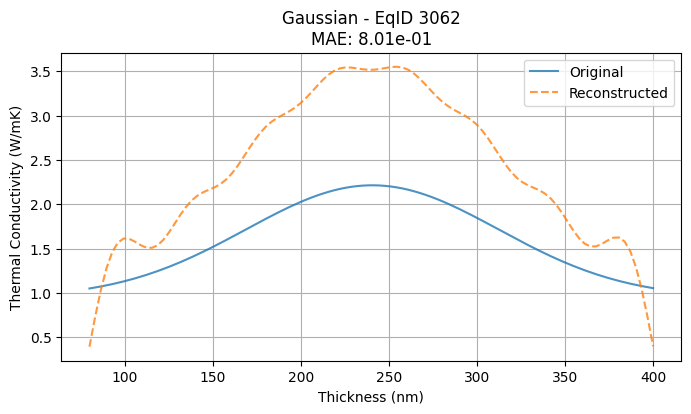


Logarithmic: Equation ID 2016  |  MAE: 1.07e+00


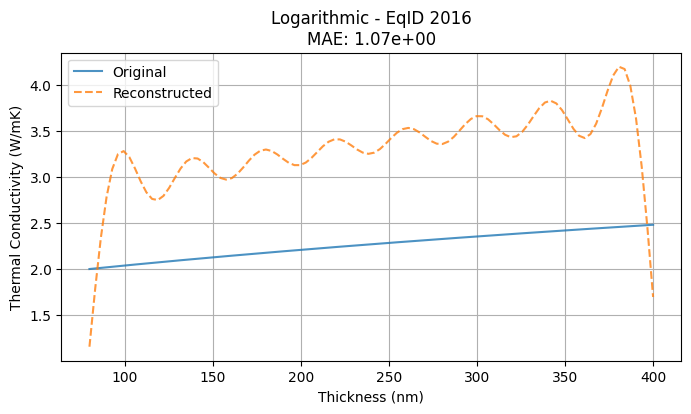


Quadratic: Equation ID 1068  |  MAE: 5.45e+00


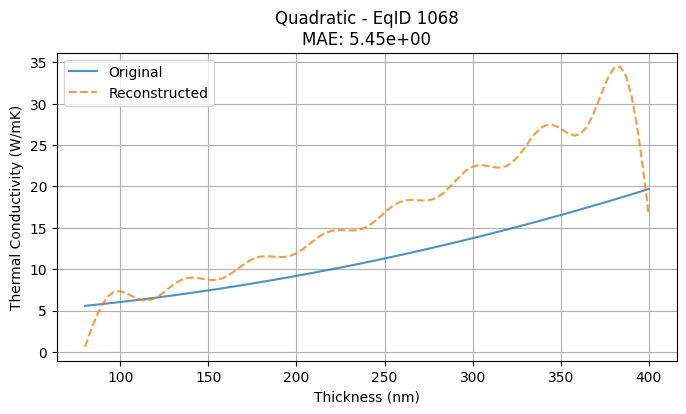

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def fourier_series_coefficients(y, x, N=15):
    L = x[-1] - x[0]
    a0 = np.mean(y)
    a_coeffs, b_coeffs = [], []
    for n in range(1, N+1):
        cos_term = np.cos(n * np.pi * x / L)
        sin_term = np.sin(n * np.pi * x / L)
        an = (2/len(x)) * np.sum(y * cos_term)
        bn = (2/len(x)) * np.sum(y * sin_term)
        a_coeffs.append(an)
        b_coeffs.append(bn)
    return [a0] + a_coeffs + b_coeffs

def reconstruct_profile(coeffs, x, N=15):
    L = x[-1] - x[0]
    a0 = coeffs[0]
    a_coeffs = coeffs[1:N+1]
    b_coeffs = coeffs[N+1:]
    y_recon = np.ones_like(x) * (a0/2)
    for n in range(1, N+1):
        y_recon += a_coeffs[n-1] * np.cos(n * np.pi * x / L)
        y_recon += b_coeffs[n-1] * np.sin(n * np.pi * x / L)
    return y_recon

def check_fourier_exact_reconstruction(csv_file, N=15, distribution_label=None):
    df = pd.read_csv(csv_file)
    eq_ids = df['Equation_ID'].unique()
    eq_id = np.random.choice(eq_ids)
    eq_data = df[df['Equation_ID'] == eq_id]
    # Always sort by x for consistent order
    sort_idx = np.argsort(eq_data['x (Thickness)'].values)
    x = eq_data['x (Thickness)'].values[sort_idx]
    y = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]
    coeffs = fourier_series_coefficients(y, x, N=N)
    y_recon = reconstruct_profile(coeffs, x, N=N)
    mae = np.mean(np.abs(y - y_recon))
    print(f"\n{distribution_label or csv_file}: Equation ID {eq_id}  |  MAE: {mae:.2e}")
    plt.figure(figsize=(8,4))
    plt.plot(x, y, label='Original', alpha=0.8)
    plt.plot(x, y_recon, '--', label='Reconstructed', alpha=0.8)
    plt.title(f'{distribution_label or csv_file} - EqID {eq_id}\nMAE: {mae:.2e}')
    plt.xlabel("Thickness (nm)")
    plt.ylabel("Thermal Conductivity (W/mK)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return mae

if __name__ == "__main__":
    files = {
        "Gaussian": "thermal_conductivity_gaussian_20250207_155153.csv",
        "Logarithmic": "thermal_conductivity_logarithmic_20250207_154245.csv",
        "Quadratic": "thermal_conductivity_quadratic_20250207_153400.csv"
    }
    for label, fname in files.items():
        check_fourier_exact_reconstruction(fname, N=15, distribution_label=label)



🔁 Running Fourier Expansion with N = 15

📂 Processing Gaussian distribution from thermal_conductivity_gaussian_20250207_155153.csv


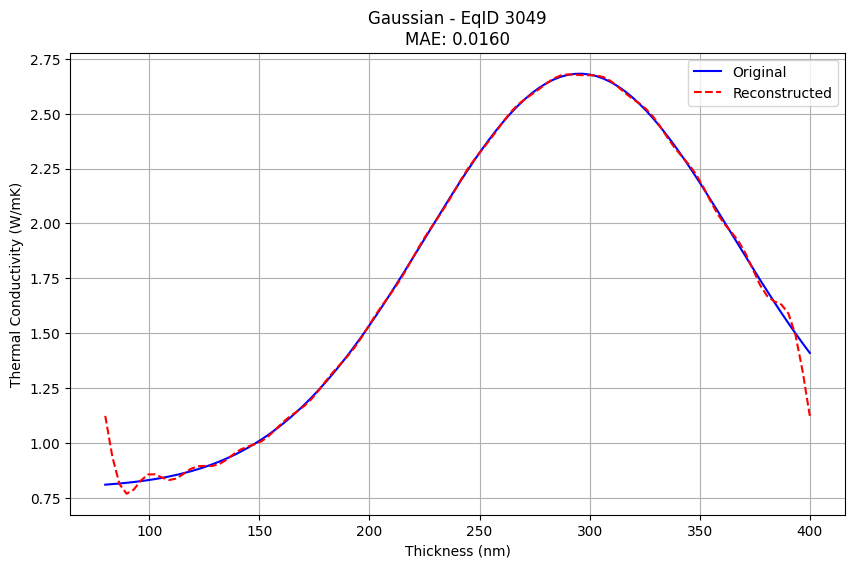

✅ Equation ID: 3049
📉 MAE: 0.015987
📸 Saved plot to Gaussian_reconstruction_N15.png

📂 Processing Logarithmic distribution from thermal_conductivity_logarithmic_20250207_154245.csv


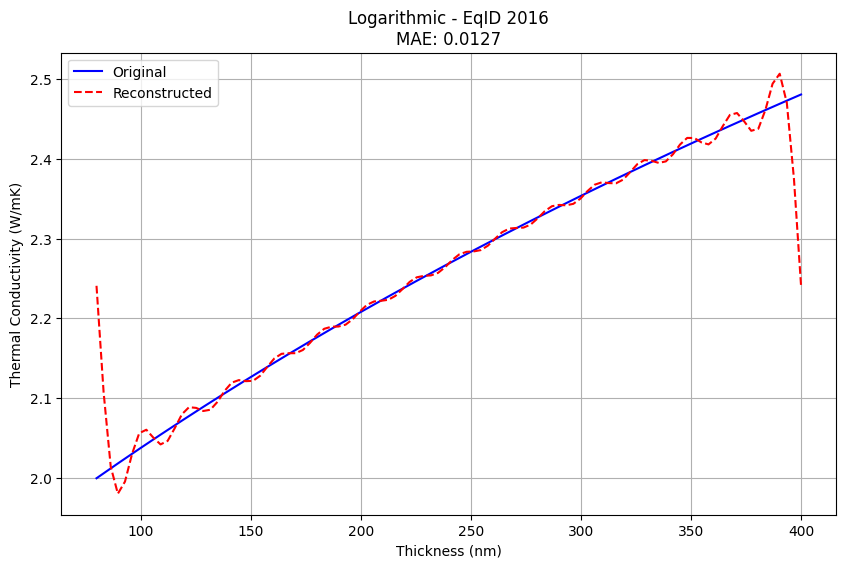

✅ Equation ID: 2016
📉 MAE: 0.012723
📸 Saved plot to Logarithmic_reconstruction_N15.png

📂 Processing Quadratic distribution from thermal_conductivity_quadratic_20250207_153400.csv


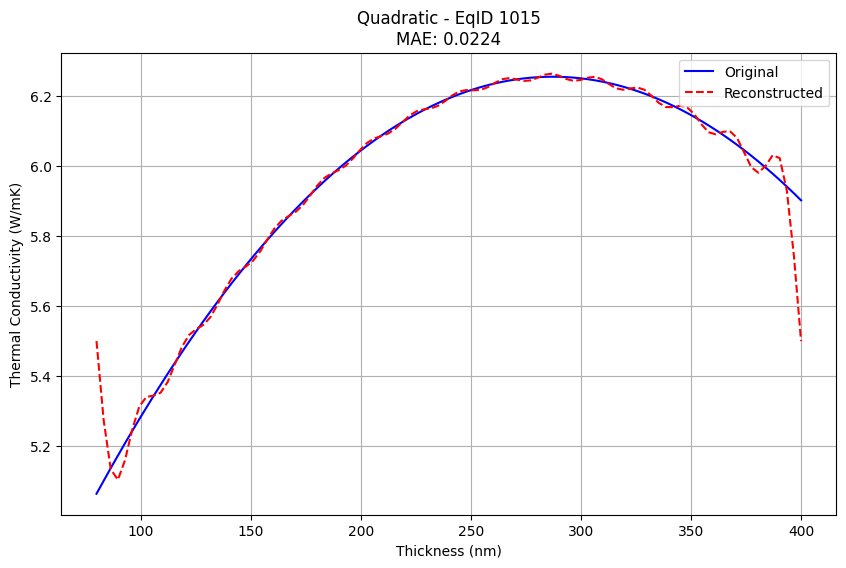

✅ Equation ID: 1015
📉 MAE: 0.022350
📸 Saved plot to Quadratic_reconstruction_N15.png

🔁 Running Fourier Expansion with N = 20

📂 Processing Gaussian distribution from thermal_conductivity_gaussian_20250207_155153.csv


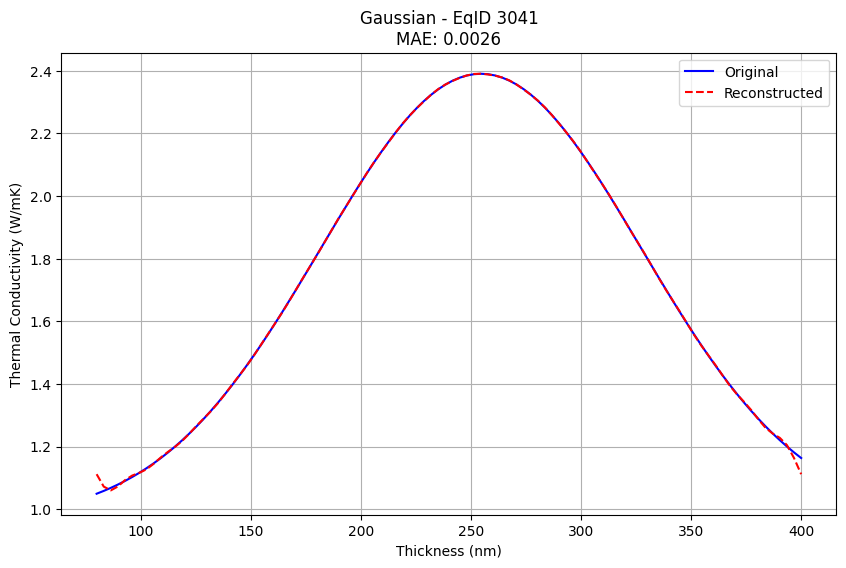

✅ Equation ID: 3041
📉 MAE: 0.002573
📸 Saved plot to Gaussian_reconstruction_N20.png

📂 Processing Logarithmic distribution from thermal_conductivity_logarithmic_20250207_154245.csv


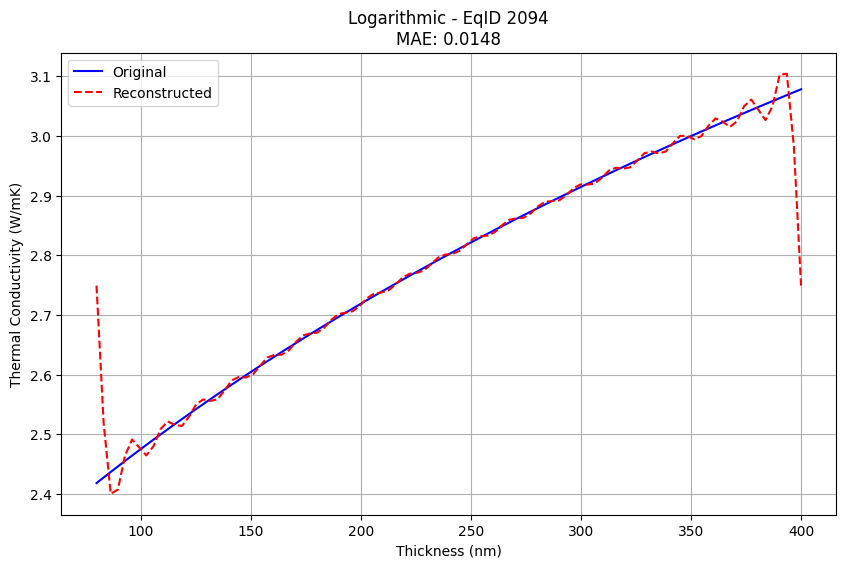

✅ Equation ID: 2094
📉 MAE: 0.014811
📸 Saved plot to Logarithmic_reconstruction_N20.png

📂 Processing Quadratic distribution from thermal_conductivity_quadratic_20250207_153400.csv


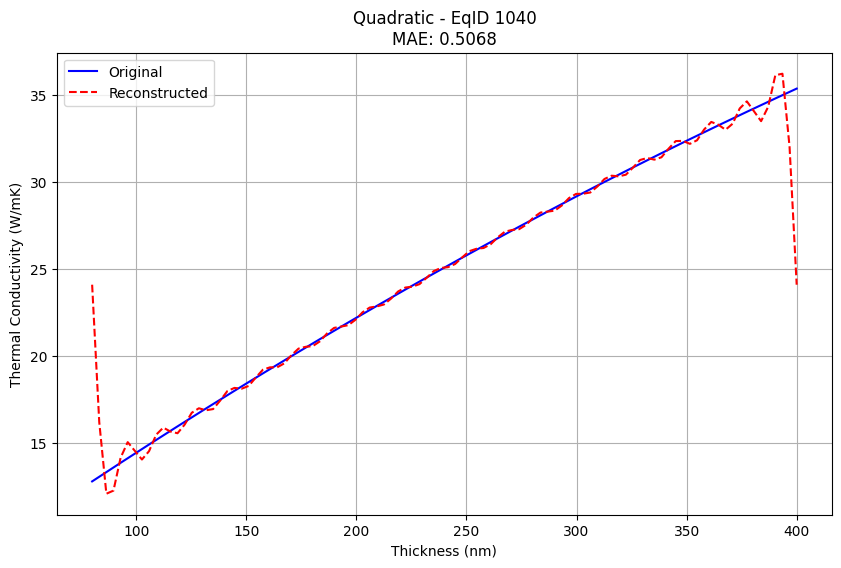

✅ Equation ID: 1040
📉 MAE: 0.506830
📸 Saved plot to Quadratic_reconstruction_N20.png

🔁 Running Fourier Expansion with N = 25

📂 Processing Gaussian distribution from thermal_conductivity_gaussian_20250207_155153.csv


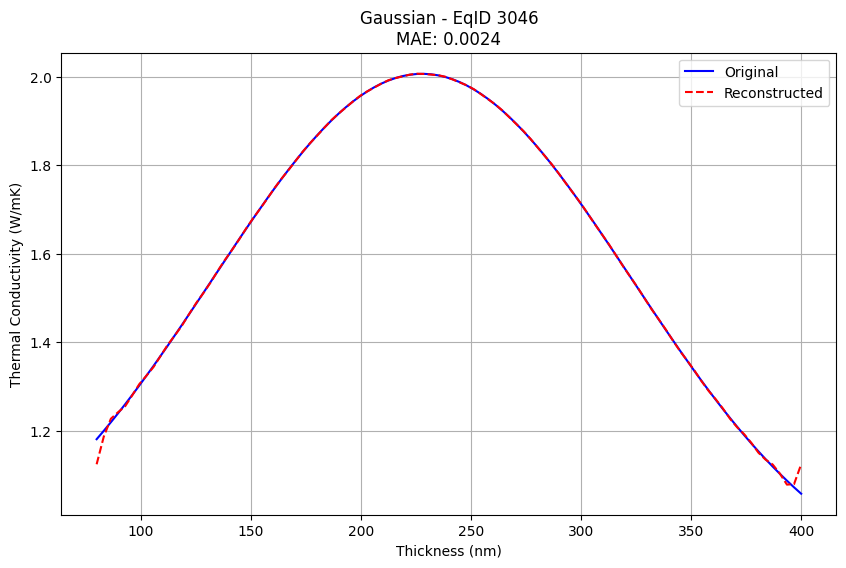

✅ Equation ID: 3046
📉 MAE: 0.002355
📸 Saved plot to Gaussian_reconstruction_N25.png

📂 Processing Logarithmic distribution from thermal_conductivity_logarithmic_20250207_154245.csv


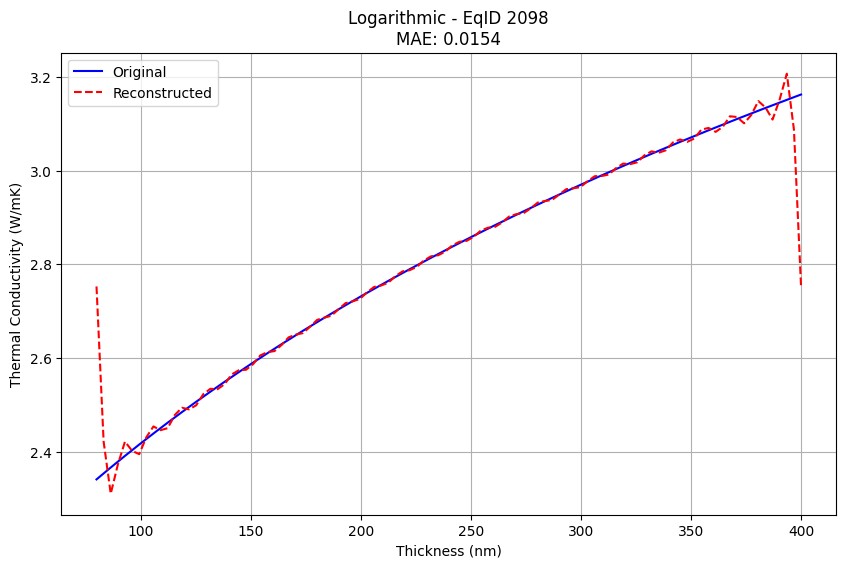

✅ Equation ID: 2098
📉 MAE: 0.015446
📸 Saved plot to Logarithmic_reconstruction_N25.png

📂 Processing Quadratic distribution from thermal_conductivity_quadratic_20250207_153400.csv


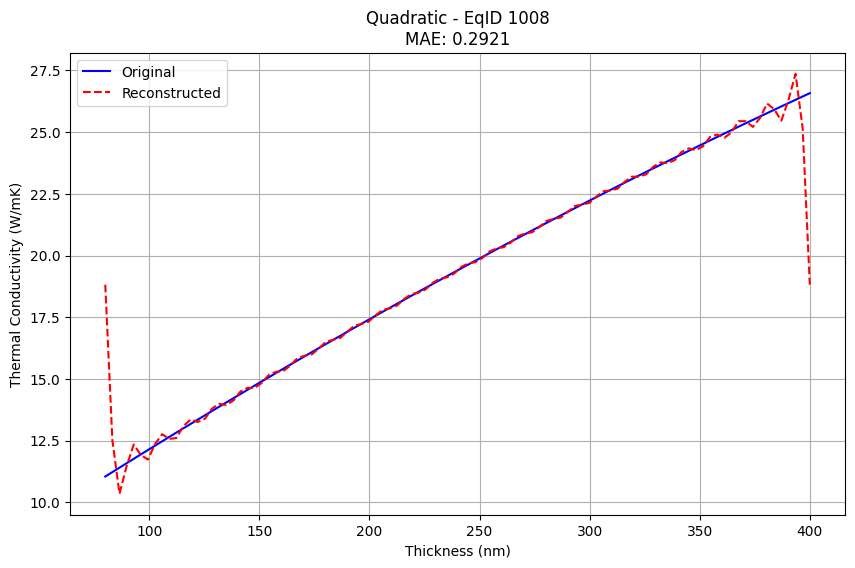

✅ Equation ID: 1008
📉 MAE: 0.292129
📸 Saved plot to Quadratic_reconstruction_N25.png


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. Fourier Coefficients Extraction Function
# ==========================================
def fourier_series_coefficients_clean(x, y, N=15):
    """
    Compute Fourier coefficients up to N terms on [0, 2π]-rescaled domain.
    """
    # Rescale x to [0, 2π]
    x_scaled = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    
    a0 = (1 / (2 * np.pi)) * np.trapz(y, x_scaled)
    a_coeffs, b_coeffs = [], []

    for n in range(1, N + 1):
        an = (1 / np.pi) * np.trapz(y * np.cos(n * x_scaled), x_scaled)
        bn = (1 / np.pi) * np.trapz(y * np.sin(n * x_scaled), x_scaled)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs


# ==========================================
# 2. Reconstruction from Fourier Coefficients
# ==========================================
def reconstruct_from_fourier_coeffs(x, coeffs, N=15):
    """
    Reconstruct signal y from Fourier coefficients over x domain.
    """
    x_scaled = 2 * np.pi * (x - x.min()) / (x.max() - x.min())

    a0 = coeffs[0]
    a = coeffs[1:N+1]
    b = coeffs[N+1:]

    y_reconstructed = np.ones_like(x_scaled) * a0

    for n in range(1, N+1):
        y_reconstructed += a[n-1] * np.cos(n * x_scaled) + b[n-1] * np.sin(n * x_scaled)

    return y_reconstructed


# ==========================================
# 3. Main Pipeline Tester
# ==========================================
def test_fourier_pipeline(file_paths, N=15):
    for dist_type, file_path in file_paths.items():
        print(f"\n📂 Processing {dist_type} distribution from {file_path}")

        df = pd.read_csv(file_path)
        eq_ids = df['Equation_ID'].unique()
        eq_id = np.random.choice(eq_ids)

        eq_data = df[df['Equation_ID'] == eq_id]
        sort_idx = np.argsort(eq_data['x (Thickness)'].values)
        x = eq_data['x (Thickness)'].values[sort_idx]
        y = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

        # Extract Fourier coefficients
        coeffs = fourier_series_coefficients_clean(x, y, N=N)

        # Reconstruct from coefficients
        y_reconstructed = reconstruct_from_fourier_coeffs(x, coeffs, N=N)

        # Compute MAE
        mae = np.mean(np.abs(y - y_reconstructed))

        # Plot and save
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'b-', label='Original')
        plt.plot(x, y_reconstructed, 'r--', label='Reconstructed')
        plt.title(f'{dist_type} - EqID {eq_id}\nMAE: {mae:.4f}')
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.legend()
        plt.grid(True)

        fname = f'{dist_type}_reconstruction_N{N}.png'
        plt.savefig(fname)
        plt.show()

        print(f"✅ Equation ID: {eq_id}")
        print(f"📉 MAE: {mae:.6f}")
        print(f"📸 Saved plot to {fname}")


# ==========================================
# 4. Driver Code
# ==========================================
if __name__ == "__main__":
    file_paths = {
        'Gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'Logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'Quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    for N in [15, 20, 25]:
        print("\n" + "="*60)
        print(f"🔁 Running Fourier Expansion with N = {N}")
        print("="*60)
        test_fourier_pipeline(file_paths, N=N)


Processing data files...
Loading gaussian data from thermal_conductivity_gaussian_20250207_155153.csv
Loading logarithmic data from thermal_conductivity_logarithmic_20250207_154245.csv
Loading quadratic data from thermal_conductivity_quadratic_20250207_153400.csv
Processed 1740500 data points across 3 distribution types
Training model...
Epoch 1/50: Train Loss = 0.401286, Val Loss = 0.356493
Saved best model.
Epoch 2/50: Train Loss = 0.382927, Val Loss = 0.370820
Epoch 3/50: Train Loss = 0.377296, Val Loss = 0.355891
Saved best model.
Epoch 4/50: Train Loss = 0.374132, Val Loss = 0.371778
Epoch 5/50: Train Loss = 0.371431, Val Loss = 0.353151
Saved best model.
Epoch 6/50: Train Loss = 0.369522, Val Loss = 0.361609
Epoch 7/50: Train Loss = 0.368454, Val Loss = 0.375450
Epoch 8/50: Train Loss = 0.366593, Val Loss = 0.364797
Epoch 9/50: Train Loss = 0.365189, Val Loss = 0.344244
Saved best model.
Epoch 10/50: Train Loss = 0.364186, Val Loss = 0.357855
Epoch 11/50: Train Loss = 0.363117, V

/tmp/ipykernel_28157/2474534193.py:214: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/best_model.pth'))


Pipeline complete.
All visualizations saved under 'visualizations/'


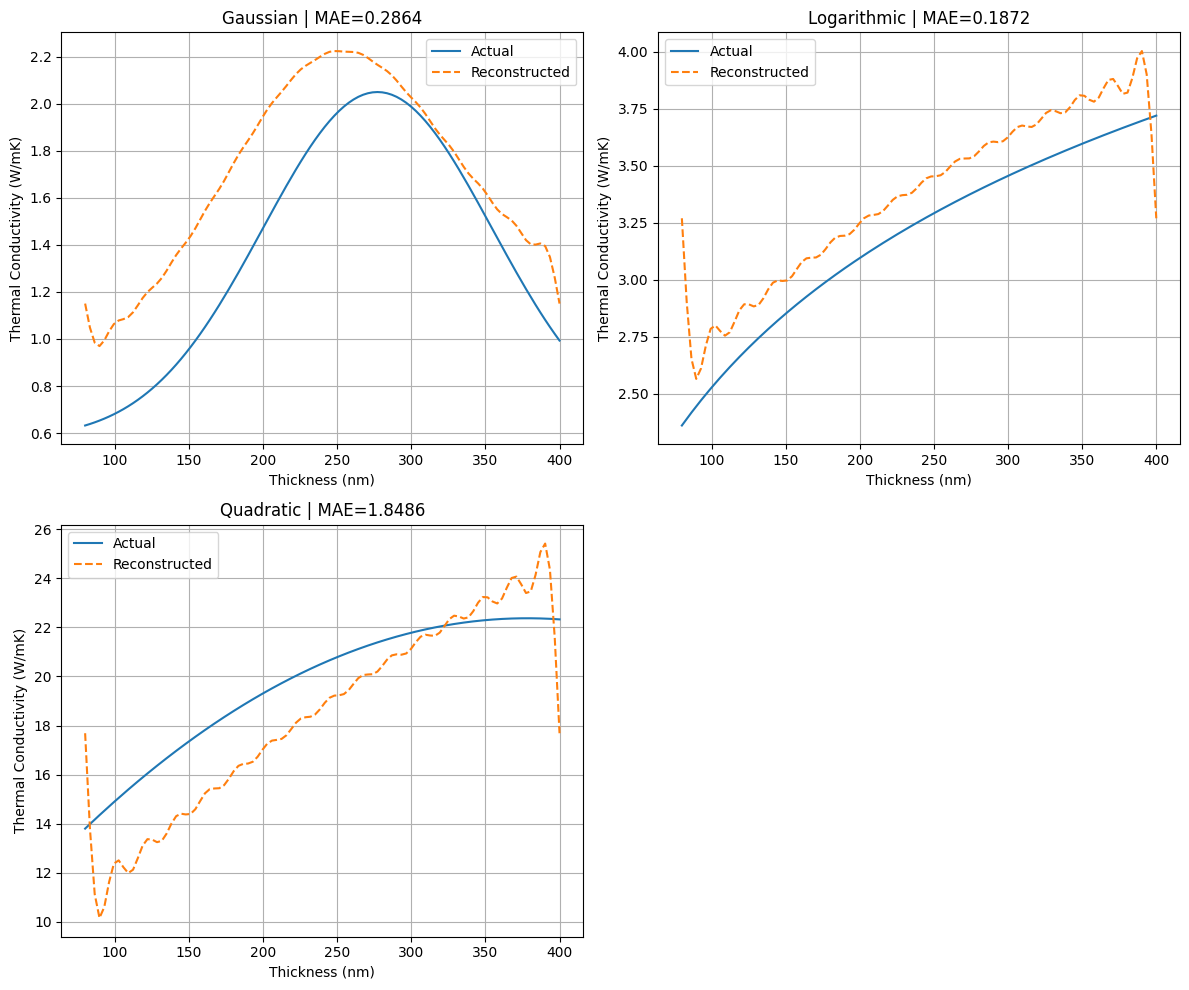

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import os

# =============================
# 1. Fourier Series Processing
# =============================

def fourier_series_coefficients(y_values, x_values, N=15):
    """Compute Fourier coefficients on [0, 2π]-rescaled domain using integration."""
    x_scaled = 2 * np.pi * (x_values - x_values.min()) / (x_values.max() - x_values.min())

    a0 = (1 / (2 * np.pi)) * np.trapz(y_values, x_scaled)
    a_coeffs, b_coeffs = [], []

    for n in range(1, N + 1):
        an = (1 / np.pi) * np.trapz(y_values * np.cos(n * x_scaled), x_scaled)
        bn = (1 / np.pi) * np.trapz(y_values * np.sin(n * x_scaled), x_scaled)
        a_coeffs.append(an)
        b_coeffs.append(bn)

    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================

def process_data(data_files, N=15):
    features_list, targets_list, eq_ids = [], [], []
    reference_profiles = {}

    print("Processing data files...")
    for eq_type, file_path in data_files.items():
        print(f"Loading {eq_type} data from {file_path}")
        df = pd.read_csv(file_path)
        reference_profiles[eq_type] = {}

        for eq_id in df['Equation_ID'].unique():
            eq_data = df[df['Equation_ID'] == eq_id]

            sort_idx = np.argsort(eq_data['x (Thickness)'].values)
            x_values = eq_data['x (Thickness)'].values[sort_idx]
            y_values = eq_data['y (Thermal Conductivity Profile)'].values[sort_idx]

            reference_profiles[eq_type][eq_id] = {'x': x_values, 'y': y_values}

            coeffs = fourier_series_coefficients(y_values, x_values, N=N)

            for i in range(len(x_values)):
                features_list.append([
                    x_values[i],
                    eq_data['ModelRatio'].values[sort_idx][i],
                    eq_data['Tdelay'].values[sort_idx][i]
                ])
                targets_list.append(coeffs + [y_values[i]])
                eq_ids.append(eq_type)

    features_df = pd.DataFrame(features_list, columns=['x', 'ModelRatio', 'TimeDelay'])
    targets_df = pd.DataFrame(targets_list, columns=[f'Fourier_{i}' for i in range(2*N+1)] + ['ThermalConductivity'])

    print(f"Processed {len(features_df)} data points across {len(reference_profiles)} distribution types")
    return features_df, targets_df, eq_ids, reference_profiles

# =============================
# 3. Dataset Definition
# =============================

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# =============================
# 4. Model Definition
# =============================

class FourierNN(nn.Module):
    def __init__(self, input_dim, output_dim=32):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.network(x)

# =============================
# 5. Reconstruction Function
# =============================

def reconstruct_profile(coeffs_predicted, x_values, N=15):
    x_scaled = 2 * np.pi * (x_values - x_values.min()) / (x_values.max() - x_values.min())
    a0 = coeffs_predicted[0]
    a_coeffs = coeffs_predicted[1:N+1]
    b_coeffs = coeffs_predicted[N+1:2*N+1]
    y_reconstructed = np.ones_like(x_scaled) * a0

    for n in range(1, N + 1):
        y_reconstructed += a_coeffs[n-1] * np.cos(n * x_scaled) + b_coeffs[n-1] * np.sin(n * x_scaled)

    return y_reconstructed

# =============================
# 6. Main Function
# =============================

def main():
    start_time = time.time()
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    N = 15
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)

    feature_scaler = StandardScaler()
    features_normalized = feature_scaler.fit_transform(features_df.values)

    target_scaler = StandardScaler()
    targets_normalized = target_scaler.fit_transform(targets_df.values)

    X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
        features_normalized, targets_normalized, eq_ids,
        test_size=0.2, random_state=42, stratify=eq_ids
    )

    train_loader = DataLoader(ThermalConductivityDataset(X_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(ThermalConductivityDataset(X_test, y_test), batch_size=32)

    model = FourierNN(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_loss = float('inf')
    patience, counter, epochs = 10, 0, 50
    train_losses, val_losses = [], []

    print("Training model...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features_batch, targets_batch in train_loader:
            optimizer.zero_grad()
            outputs_batch = model(features_batch)
            loss_batch = criterion(outputs_batch, targets_batch)
            loss_batch.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss_batch.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features_batch, targets_batch in test_loader:
                outputs_batch = model(features_batch)
                val_loss += criterion(outputs_batch, targets_batch).item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0
            torch.save(model.state_dict(), 'models/best_model.pth')
            print("Saved best model.")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(torch.load('models/best_model.pth'))

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig('visualizations/loss_curve.png')
    plt.close()

    print("Generating visualizations...")
    model.eval()
    eq_types = list(data_files.keys())
    plt.figure(figsize=(12, 10))

    for i, eq_type in enumerate(eq_types):
        eq_indices = [j for j, eq in enumerate(eq_test) if eq == eq_type]
        if not eq_indices:
            continue
        sample_idx = eq_indices[0]
        sample_features = X_test[sample_idx]

        eq_id = list(reference_profiles[eq_type].keys())[0]
        x_vals = reference_profiles[eq_type][eq_id]['x']
        y_actual = reference_profiles[eq_type][eq_id]['y']

        with torch.no_grad():
            prediction = model(torch.FloatTensor(sample_features.reshape(1, -1))).numpy()[0]
        prediction_original = target_scaler.inverse_transform(prediction.reshape(1, -1))[0]
        y_reconstructed = reconstruct_profile(prediction_original[:-1], x_vals, N=N)

        mae = mean_absolute_error(y_actual, y_reconstructed)
        plt.subplot(2, 2, i + 1)
        plt.plot(x_vals, y_actual, label='Actual')
        plt.plot(x_vals, y_reconstructed, '--', label='Reconstructed')
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.title(f'{eq_type.capitalize()} | MAE={mae:.4f}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('visualizations/final_reconstruction_profiles.png')
    print("Pipeline complete.")
    print("All visualizations saved under 'visualizations/'")

if __name__ == "__main__":
    main()


In [2]:
# Improved Fourier NN pipeline with normalized Fourier coefficients, stable MAPE, multiple architectures

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from scipy.signal import savgol_filter
import os
import time

# =============================
# 1. Fourier Processing
# =============================
def fourier_series_coefficients(y_values, x_values, N=15):
    x_scaled = 2 * np.pi * (x_values - x_values.min()) / (x_values.max() - x_values.min())
    a0 = (1 / (2 * np.pi)) * np.trapz(y_values, x_scaled)
    a_coeffs, b_coeffs = [], []
    for n in range(1, N + 1):
        an = (1 / np.pi) * np.trapz(y_values * np.cos(n * x_scaled), x_scaled)
        bn = (1 / np.pi) * np.trapz(y_values * np.sin(n * x_scaled), x_scaled)
        a_coeffs.append(an)
        b_coeffs.append(bn)
    return [a0] + a_coeffs + b_coeffs

# =============================
# 2. Data Processing
# =============================
def process_data(data_files, N=15):
    features, targets, eq_ids = [], [], []
    reference = {}
    for dist, path in data_files.items():
        df = pd.read_csv(path)
        reference[dist] = {}
        for eq_id in df['Equation_ID'].unique():
            eq_df = df[df['Equation_ID'] == eq_id]
            idx = np.argsort(eq_df['x (Thickness)'].values)
            x = eq_df['x (Thickness)'].values[idx]
            y = eq_df['y (Thermal Conductivity Profile)'].values[idx]
            reference[dist][eq_id] = {'x': x, 'y': y}
            coeffs = fourier_series_coefficients(y, x, N)
            for i in range(len(x)):
                features.append([
                    x[i], eq_df['ModelRatio'].values[idx][i], eq_df['Tdelay'].values[idx][i]
                ])
                targets.append(coeffs)
                eq_ids.append(dist)
    X = pd.DataFrame(features, columns=['x', 'ModelRatio', 'TimeDelay'])
    Y = pd.DataFrame(targets, columns=[f'Fourier_{i}' for i in range(2*N+1)])
    return X, Y, eq_ids, reference

# =============================
# 3. Dataset
# =============================
class ThermalDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.FloatTensor(X)
        self.Y = torch.FloatTensor(Y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.Y[i]

# =============================
# 4. Architectures
# =============================
class BaseNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[128, 256, 128], dropout=0.1):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(), nn.BatchNorm1d(h), nn.Dropout(dropout)]
            prev = h
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# =============================
# 5. Reconstruct
# =============================
def reconstruct(coeffs, x, N):
    x_scaled = 2 * np.pi * (x - x.min()) / (x.max() - x.min())
    a0, a, b = coeffs[0], coeffs[1:N+1], coeffs[N+1:2*N+1]
    y = np.ones_like(x_scaled) * a0
    for n in range(1, N+1):
        y += a[n-1]*np.cos(n*x_scaled) + b[n-1]*np.sin(n*x_scaled)
    return savgol_filter(y, 7, 3)

# =============================
# 6. Evaluation
# =============================
def evaluate_and_plot(model, scaler_y, X_test, eq_test, ref_profiles, model_name, N):
    os.makedirs(f'visualizations/{model_name}', exist_ok=True)
    mape_summary = {}
    model.eval()
    for dist in set(eq_test):
        idx = [i for i, eq in enumerate(eq_test) if eq == dist]
        i = idx[0]
        x = torch.FloatTensor(X_test[i].reshape(1, -1))
        with torch.no_grad():
            pred = model(x).numpy()[0]
        pred_orig = scaler_y.inverse_transform(pred.reshape(1, -1))[0]
        eq_id = list(ref_profiles[dist].keys())[0]
        x_vals = ref_profiles[dist][eq_id]['x']
        y_true = ref_profiles[dist][eq_id]['y']
        y_pred = reconstruct(pred_orig, x_vals, N)
        mae = mean_absolute_error(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred)/(np.abs(y_true) + 1e-10))) * 100
        mape_summary[dist] = mape
        plt.figure()
        plt.plot(x_vals, y_true, label='Actual')
        plt.plot(x_vals, y_pred, '--', label='Predicted')
        plt.title(f'{dist.capitalize()} | MAE={mae:.4f}, MAPE={mape:.2f}%')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'visualizations/{model_name}/{dist}.png')
        plt.close()
    return mape_summary

# =============================
# 7. Training
# =============================
def train_model(model, name, X_train, X_test, y_train, y_test, scaler_y, ref_profiles, eq_test, N):
    loader = DataLoader(ThermalDataset(X_train, y_train), batch_size=64, shuffle=True)
    test_loader = DataLoader(ThermalDataset(X_test, y_test), batch_size=64)
    optim = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=5)
    best_loss, counter = float('inf'), 0
    for epoch in range(50):
        model.train()
        loss = 0
        for xb, yb in loader:
            optim.zero_grad()
            pred = model(xb)
            l = loss_fn(pred, yb)
            l.backward()
            optim.step()
            loss += l.item()
        loss /= len(loader)
        with torch.no_grad():
            val_loss = sum(loss_fn(model(xb), yb).item() for xb, yb in test_loader) / len(test_loader)
        scheduler.step(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'models/{name}.pth')
            counter = 0
        else:
            counter += 1
            if counter > 10:
                break
    model.load_state_dict(torch.load(f'models/{name}.pth', weights_only=True))
    return evaluate_and_plot(model, scaler_y, X_test, eq_test, ref_profiles, name, N)

# =============================
# 8. Main
# =============================
def main():
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }
    configs = [
        (15, [64, 128, 64]),
        (20, [128, 256, 128]),
        (25, [256, 256]),
        (30, [512, 256, 128]),
        (15, [128, 128, 128, 64])
    ]
    for i, (N, layers) in enumerate(configs):
        X_df, Y_df, eq_ids, ref = process_data(data_files, N=N)
        X_scaler, Y_scaler = StandardScaler(), StandardScaler()
        X = X_scaler.fit_transform(X_df.values)
        Y = Y_scaler.fit_transform(Y_df.values)
        X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(X, Y, eq_ids, test_size=0.2, stratify=eq_ids)
        model = BaseNN(input_dim=X.shape[1], output_dim=Y.shape[1], hidden_layers=layers)
        model_name = f"FourierNN_V{i+1}_N{N}"
        print(f"\nTraining {model_name}...")
        summary = train_model(model, model_name, X_train, X_test, Y_train, Y_test, Y_scaler, ref, eq_test, N)
        for dist, mape in summary.items():
            print(f"  {dist.capitalize()}: MAPE = {mape:.2f}%")

# if __name__ == '__main__':
#     main()
def run_extra_models():
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # New configurations: more layers, skip style, larger capacity
    new_configs = [
        (20, [128, 128, 128, 64]),          # V6 - uniform mid-depth
        (25, [512, 256, 128]),              # V7 - very wide to narrow
        (15, [256, 256, 256]),              # V8 - consistent deep
        (30, [512, 512, 256, 128]),         # V9 - very deep and wide
        (25, [128, 64, 128, 64])            # V10 - sandwich skip-like
    ]

    for i, (N, layers) in enumerate(new_configs):
        model_name = f"FourierNN_V{i+6}_N{N}"
        print(f"\n🔥 Training {model_name}...")

        X_df, Y_df, eq_ids, ref = process_data(data_files, N=N)
        X_scaler, Y_scaler = StandardScaler(), StandardScaler()
        X = X_scaler.fit_transform(X_df.values)
        Y = Y_scaler.fit_transform(Y_df.values)

        X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(
            X, Y, eq_ids, test_size=0.2, stratify=eq_ids
        )

        model = BaseNN(input_dim=X.shape[1], output_dim=Y.shape[1], hidden_layers=layers)
        summary = train_model(model, model_name, X_train, X_test, Y_train, Y_test, Y_scaler, ref, eq_test, N)

        for dist, mape in summary.items():
            print(f"  {dist.capitalize()}: MAPE = {mape:.2f}%")

# if __name__ == "__main__":
#     run_extra_models()



In [3]:
def train_golden_model():
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Configuration
    N = 25
    hidden_layers = [256, 256]
    model_name = "FourierNN_Golden_N25"

    print(f"\n🏆 Training {model_name}...")

    # Data processing
    X_df, Y_df, eq_ids, ref = process_data(data_files, N=N)
    X_scaler, Y_scaler = StandardScaler(), StandardScaler()
    X = X_scaler.fit_transform(X_df.values)
    Y = Y_scaler.fit_transform(Y_df.values)

    X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(
        X, Y, eq_ids, test_size=0.2, stratify=eq_ids
    )

    # Model
    model = BaseNN(
        input_dim=X.shape[1],
        output_dim=Y.shape[1],
        hidden_layers=hidden_layers,
        dropout=0.2  # Increase dropout slightly
    )

    loader = DataLoader(ThermalDataset(X_train, Y_train), batch_size=128, shuffle=True)
    test_loader = DataLoader(ThermalDataset(X_test, Y_test), batch_size=128)
    optim = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=5)

    # Training loop
    best_loss, counter = float('inf'), 0
    for epoch in range(75):
        model.train()
        loss = 0
        for xb, yb in loader:
            optim.zero_grad()
            pred = model(xb)
            l = loss_fn(pred, yb)
            l.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Clip gradients
            optim.step()
            loss += l.item()
        loss /= len(loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                val_loss += loss_fn(model(xb), yb).item()
        val_loss /= len(test_loader)
        scheduler.step(val_loss)

        print(f"  Epoch {epoch+1} - Train Loss: {loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'models/{model_name}.pth')
            counter = 0
        else:
            counter += 1
            if counter >= 15:  # early stopping patience
                print(f"⏹ Early stopping at epoch {epoch+1}")
                break

    # Evaluation
    model.load_state_dict(torch.load(f'models/{model_name}.pth', weights_only=True))
    summary = evaluate_and_plot(model, Y_scaler, X_test, eq_test, ref, model_name, N)
    for dist, mape in summary.items():
        print(f"✅ {dist.capitalize()}: MAPE = {mape:.2f}%")

if __name__ == "__main__":
    train_golden_model()



🏆 Training FourierNN_Golden_N25...
  Epoch 1 - Train Loss: 0.417258, Val Loss: 0.370439
  Epoch 2 - Train Loss: 0.390363, Val Loss: 0.369502
  Epoch 3 - Train Loss: 0.385012, Val Loss: 0.361887
  Epoch 4 - Train Loss: 0.383227, Val Loss: 0.364229
  Epoch 5 - Train Loss: 0.381901, Val Loss: 0.357455
  Epoch 6 - Train Loss: 0.381253, Val Loss: 0.361186
  Epoch 7 - Train Loss: 0.381011, Val Loss: 0.357773
  Epoch 8 - Train Loss: 0.381039, Val Loss: 0.360464
  Epoch 9 - Train Loss: 0.381148, Val Loss: 0.360499
  Epoch 10 - Train Loss: 0.381109, Val Loss: 0.355399
  Epoch 11 - Train Loss: 0.381039, Val Loss: 0.358797
  Epoch 12 - Train Loss: 0.381018, Val Loss: 0.357474
  Epoch 13 - Train Loss: 0.381102, Val Loss: 0.358307
  Epoch 14 - Train Loss: 0.380721, Val Loss: 0.355915
  Epoch 15 - Train Loss: 0.380777, Val Loss: 0.362172
  Epoch 16 - Train Loss: 0.381292, Val Loss: 0.366059
  Epoch 17 - Train Loss: 0.375562, Val Loss: 0.352192
  Epoch 18 - Train Loss: 0.375287, Val Loss: 0.352524
 

In [5]:
import random
import matplotlib.pyplot as plt

def visualize_multiple_samples(model, scaler_y, X_test, eq_test, ref_profiles, model_name, N, samples_per_type=5):
    """
    Visualize multiple reconstructed profiles for each distribution type.
    """
    model.eval()
    dist_types = ['gaussian', 'logarithmic', 'quadratic']
    os.makedirs(f'visualizations/{model_name}_multiple', exist_ok=True)

    for dist in dist_types:
        idxs = [i for i, eq in enumerate(eq_test) if eq == dist]
        if len(idxs) == 0:
            print(f"No samples for {dist}")
            continue

        selected_idxs = random.sample(idxs, min(samples_per_type, len(idxs)))

        for j, sample_idx in enumerate(selected_idxs):
            x = torch.FloatTensor(X_test[sample_idx].reshape(1, -1))
            with torch.no_grad():
                pred = model(x).numpy()[0]

            pred_orig = scaler_y.inverse_transform(pred.reshape(1, -1))[0]

            eq_id = list(ref_profiles[dist].keys())[0]
            x_vals = ref_profiles[dist][eq_id]['x']
            y_true = ref_profiles[dist][eq_id]['y']
            y_pred = reconstruct(pred_orig, x_vals, N)

            mae = mean_absolute_error(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-10))) * 100

            plt.figure(figsize=(7, 5))
            plt.plot(x_vals, y_true, label='Actual', linewidth=2)
            plt.plot(x_vals, y_pred, '--', label='Predicted', linewidth=2)
            plt.title(f'{dist.capitalize()} Sample #{j+1}\nMAE={mae:.4f}, MAPE={mape:.2f}%')
            plt.xlabel('Thickness (nm)')
            plt.ylabel('Thermal Conductivity (W/mK)')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'visualizations/{model_name}_multiple/{dist}_sample_{j+1}.png')
            plt.close()

    print(f"\n✅ Saved all sample visualizations under visualizations/{model_name}_multiple/")

# Example usage after training:
# 1. Reload model architecture
model = BaseNN(input_dim=3, output_dim=51, hidden_layers=[256, 256], dropout=0.2)
model.load_state_dict(torch.load('models/FourierNN_Golden_N25.pth', weights_only=True))
model.eval()

# 2. Reprocess data
data_files = {
    'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
    'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
    'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
}
X_df, Y_df, eq_ids, ref_profiles = process_data(data_files, N=25)
X_scaler, Y_scaler = StandardScaler(), StandardScaler()
X = X_scaler.fit_transform(X_df.values)
Y = Y_scaler.fit_transform(Y_df.values)
X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(X, Y, eq_ids, test_size=0.2, stratify=eq_ids)

# 3. Then you can call visualization
visualize_multiple_samples(model, Y_scaler, X_test, eq_test, ref_profiles, model_name="FourierNN_Golden_N25", N=25)



✅ Saved all sample visualizations under visualizations/FourierNN_Golden_N25_multiple/


In [ ]:
def train_goldenV2_model():
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    # Data
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    # Configuration
    N = 25
    hidden_layers = [256, 256]
    model_name = "FourierNN_GoldenV2_N25"

    print(f"\n🏆 Pretraining {model_name} on all distributions...")

    # 1. Data processing
    X_df, Y_df, eq_ids, ref_profiles = process_data(data_files, N=N)
    X_scaler, Y_scaler = StandardScaler(), StandardScaler()
    X = X_scaler.fit_transform(X_df.values)
    Y = Y_scaler.fit_transform(Y_df.values)

    X_train, X_test, Y_train, Y_test, eq_train, eq_test = train_test_split(
        X, Y, eq_ids, test_size=0.2, stratify=eq_ids
    )

    model = BaseNN(
        input_dim=X.shape[1],
        output_dim=Y.shape[1],
        hidden_layers=hidden_layers,
        dropout=0.2
    )

    loader = DataLoader(ThermalDataset(X_train, Y_train), batch_size=128, shuffle=True)
    test_loader = DataLoader(ThermalDataset(X_test, Y_test), batch_size=128)

    optim = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=5)

    best_loss, counter = float('inf'), 0
    for epoch in range(75):
        model.train()
        total_loss = 0
        for xb, yb in loader:
            optim.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optim.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                val_loss += loss_fn(model(xb), yb).item()
        avg_val_loss = val_loss / len(test_loader)

        scheduler.step(avg_val_loss)
        print(f"  Pretrain Epoch {epoch+1}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), f'models/{model_name}_pretrained.pth')
            counter = 0
        else:
            counter += 1
            if counter >= 15:
                print(f"⏹ Early stopping Pretraining at epoch {epoch+1}")
                break

    # 2. Fine-tuning ONLY on Gaussian data
    print("\n🎯 Fine-tuning only on Gaussian profiles...")

    model.load_state_dict(torch.load(f'models/{model_name}_pretrained.pth', weights_only=True))
    gaussian_idxs = [i for i, eq in enumerate(eq_train) if eq == 'gaussian']

    X_gaussian = X_train[gaussian_idxs]
    Y_gaussian = Y_train[gaussian_idxs]

    fine_tune_loader = DataLoader(ThermalDataset(X_gaussian, Y_gaussian), batch_size=32, shuffle=True)

    fine_optim = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    fine_scheduler = ReduceLROnPlateau(fine_optim, mode='min', factor=0.5, patience=3)

    best_fine_loss, counter = float('inf'), 0
    for epoch in range(20):
        model.train()
        total_loss = 0
        for xb, yb in fine_tune_loader:
            fine_optim.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            fine_optim.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(fine_tune_loader)

        fine_scheduler.step(avg_train_loss)
        print(f"  Fine-tune Epoch {epoch+1}: Fine-tune Loss = {avg_train_loss:.6f}")

        if avg_train_loss < best_fine_loss:
            best_fine_loss = avg_train_loss
            torch.save(model.state_dict(), f'models/{model_name}.pth')
            counter = 0
        else:
            counter += 1
            if counter >= 7:
                print(f"⏹ Early stopping Fine-tuning at epoch {epoch+1}")
                break

    # 3. Evaluate Final GoldenV2
    model.load_state_dict(torch.load(f'models/{model_name}.pth', weights_only=True))
    summary = evaluate_and_plot(model, Y_scaler, X_test, eq_test, ref_profiles, model_name, N)

    for dist, mape in summary.items():
        print(f"✅ {dist.capitalize()} (After Fine-tune): MAPE = {mape:.2f}%")

    return model, Y_scaler, X_test, eq_test, ref_profiles, model_name, N

# Call it like this:
if __name__ == "__main__":
    model, Y_scaler, X_test, eq_test, ref_profiles, model_name, N = train_goldenV2_model()
    visualize_multiple_samples(model, Y_scaler, X_test, eq_test, ref_profiles, model_name, N)


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from torch.optim.lr_scheduler import CosineAnnealingLR
import os, time

# Assumes: `fourier_series_coefficients`, `reconstruct_profile`, `process_data` already defined

class ThermalConductivityDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self): return len(self.features)
    def __getitem__(self, idx): return self.features[idx], self.targets[idx]

# =======================================
# 📐 Define 5 Model Variants
# =======================================
def build_model(variant, input_dim, output_dim):
    class Sine(nn.Module):
        def forward(self, x): return torch.sin(x)

    if variant == 'V6':  # Wider baseline
        return nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Linear(128, 256), nn.ReLU(), nn.BatchNorm1d(256),
            nn.Linear(256, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Dropout(0.1), nn.Linear(128, output_dim)
        )
    elif variant == 'V7':  # SIREN-style
        return nn.Sequential(
            nn.Linear(input_dim, 64), Sine(),
            nn.Linear(64, 128), Sine(),
            nn.Linear(128, 256), Sine(),
            nn.Linear(256, output_dim)
        )
    elif variant == 'V8':  # Shallow but wide
        return nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(512, output_dim)
        )
    elif variant == 'V9':  # ResNet-inspired skip block
        class ResBlock(nn.Module):
            def __init__(self, in_f): super().__init__()
            self.block = nn.Sequential(
                nn.Linear(in_f, in_f), nn.ReLU(), nn.Dropout(0.1),
                nn.Linear(in_f, in_f)
            )
            def forward(self, x): return x + self.block(x)

        return nn.Sequential(
            nn.Linear(input_dim, 128), nn.ReLU(),
            ResBlock(128),
            ResBlock(128),
            nn.Linear(128, output_dim)
        )
    elif variant == 'V10':  # Transformer-FFN style
        return nn.Sequential(
            nn.Linear(input_dim, 256), nn.LayerNorm(256), nn.ReLU(),
            nn.Linear(256, 128), nn.LayerNorm(128), nn.ReLU(),
            nn.Dropout(0.1), nn.Linear(128, output_dim)
        )

# =======================================
# 🔁 Main Training Loop for All Models
# =======================================
def train_all_models():
    os.makedirs('models', exist_ok=True)
    os.makedirs('visualizations', exist_ok=True)

    variants = ['V6', 'V7', 'V8', 'V9', 'V10']
    Ns = [15, 20, 25, 30, 15]  # N terms for each model
    data_files = {
        'gaussian': 'thermal_conductivity_gaussian_20250207_155153.csv',
        'logarithmic': 'thermal_conductivity_logarithmic_20250207_154245.csv',
        'quadratic': 'thermal_conductivity_quadratic_20250207_153400.csv'
    }

    for variant, N in zip(variants, Ns):
        print(f"\n🚀 Training FourierNN_{variant}_N{N}...")
        model_name = f'FourierNN_{variant}_N{N}'

        # 1. Preprocess
        features_df, targets_df, eq_ids, reference_profiles = process_data(data_files, N=N)
        fourier_cols = [f'Fourier_{i}' for i in range(2 * N + 1)]
        
        feature_scaler = StandardScaler()
        features = feature_scaler.fit_transform(features_df.values)
        
        # Only scale Fourier coefficients, not final target
        target_scaler = StandardScaler()
        targets_scaled = targets_df.copy()
        targets_scaled[fourier_cols] = target_scaler.fit_transform(targets_df[fourier_cols])
        targets_scaled['ThermalConductivity'] = targets_df['ThermalConductivity'].values  # ✅ FIX
        targets = targets_scaled[fourier_cols + ['ThermalConductivity']].values

        X_train, X_test, y_train, y_test, eq_train, eq_test = train_test_split(
            features, targets, eq_ids, test_size=0.2, random_state=42, stratify=eq_ids)

        train_loader = DataLoader(ThermalConductivityDataset(X_train, y_train), batch_size=64, shuffle=True)
        test_loader = DataLoader(ThermalConductivityDataset(X_test, y_test), batch_size=64)

        # 2. Model
        input_dim = features.shape[1]
        output_dim = targets.shape[1]
        model = build_model(variant, input_dim, output_dim)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = CosineAnnealingLR(optimizer, T_max=30)

        best_loss = float('inf')
        patience, counter, epochs = 12, 0, 60
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for xb, yb in train_loader:
                optimizer.zero_grad()
                loss = criterion(model(xb), yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            scheduler.step()
            avg_train_loss = total_loss / len(train_loader)

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for xb, yb in test_loader:
                    val_loss += criterion(model(xb), yb).item()
            avg_val_loss = val_loss / len(test_loader)

            print(f"  Epoch {epoch+1}/{epochs} - Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), f"models/{model_name}.pth")
                counter = 0
            else:
                counter += 1
                if counter >= patience: break

        # 3. Evaluation on 1 sample per distribution
        model.load_state_dict(torch.load(f"models/{model_name}.pth", weights_only=True))
        model.eval()
        os.makedirs(f"visualizations/{model_name}", exist_ok=True)
        print(f"\n📈 Evaluating {model_name}...")

        for dist in data_files:
            idxs = [i for i, e in enumerate(eq_test) if e == dist]
            if not idxs: continue
            idx = idxs[0]
            x_vals = reference_profiles[dist][list(reference_profiles[dist].keys())[0]]['x']
            y_true = reference_profiles[dist][list(reference_profiles[dist].keys())[0]]['y']
            with torch.no_grad():
                pred = model(torch.FloatTensor(X_test[idx].reshape(1, -1))).numpy()[0]
            pred_orig = target_scaler.inverse_transform(
                np.concatenate([pred[:-1], [0]]).reshape(1, -1)
            )[0][:-1]
            y_pred = reconstruct_profile(pred_orig, x_vals, N=N)

            mae = mean_absolute_error(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
            print(f"  {dist.capitalize()}: MAPE = {mape:.2f}%")

            # Plot
            plt.figure(figsize=(6, 4))
            plt.plot(x_vals, y_true, label='Actual')
            plt.plot(x_vals, y_pred, '--', label='Reconstructed')
            plt.title(f"{dist.capitalize()} | MAPE = {mape:.2f}%")
            plt.xlabel("Thickness (nm)")
            plt.ylabel("Thermal Conductivity (W/mK)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f"visualizations/{model_name}/{dist}_profile.png")
            plt.close()

if __name__ == "__main__":
    train_all_models()



🚀 Training FourierNN_V6_N15...


KeyError: 'ThermalConductivity'

In [3]:
import matplotlib.pyplot as plt

def validate_fourier_extraction_reconstruction(reference_profiles, N=15):
    """
    Validate Fourier extraction and reconstruction by selecting one sample from each distribution.
    """
    print("\n🔍 Validating Fourier Expansion -> Reconstruction on Original Data")
    plt.figure(figsize=(14, 4))

    for i, (dist_name, profiles) in enumerate(reference_profiles.items()):
        eq_id = list(profiles.keys())[0]
        x_vals = profiles[eq_id]['x']
        y_vals = profiles[eq_id]['y']

        coeffs = fourier_series_coefficients(y_vals, x_vals, N=N)
        y_reconstructed = reconstruct_profile(coeffs, x_vals, N=N)

        mae = np.mean(np.abs(y_vals - y_reconstructed))
        mape = np.mean(np.abs((y_vals - y_reconstructed) / (y_vals + 1e-8))) * 100

        plt.subplot(1, 3, i+1)
        plt.plot(x_vals, y_vals, label='Original', color='blue')
        plt.plot(x_vals, y_reconstructed, '--', label='Reconstructed', color='orange')
        plt.title(f'{dist_name.capitalize()} | MAE={mae:.4f}, MAPE={mape:.2f}%')
        plt.xlabel('Thickness (nm)')
        plt.ylabel('Thermal Conductivity (W/mK)')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.savefig("visualizations/fourier_validation_fixed_profiles.png")
    plt.show()
